#                                                       UZOP Projekt
*Early-Stage Alzheimer's Disease Prediction Using Machine Learning Models*


*Petra Dunja Grujić Ostojić*

Za projekt iz predmeta Uvod u znanost o podatcima odabrala sam članak koji opisuje primjenu modela strojnog učenja za predviđanje Alzheimerove bolesti. 

Cilj je trenirati modele tako da uoče ranu fazu bolesti kako bi se spriječilo daljnje napredovanje i poboljšala kvaliteta života pacijenata. Primjena strojnog učenja u medicinskoj dijagnostici ima veliki potencijal jer se uz precizne modele postupak može značajno ubrzati i izbjeći pogreške koje su posljedica ljudskih slabosti (subjektivnost, umor, dekoncentracija i slično).
 
Podatkovni skup na kojemu se provodi treniranje modela je javno dostupan skup iz projekta OASIS (Open Access Series of Imaging Studies) koji sam preuzela sa stranice Kaggle (https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers?resource=download). 

Znastvenici su u ovom članku primjenili nekoliko klasifikacijskih algoritama (stroj potpornih vektora, slučajne šume, stabla odluka, XGBoost, klasifikator s glasanjem (engl. Voting Classifier)) kako bi predvidjeli ima li pacijent Alzheimer. Temelj predikcije su numerički podatci dobiveni iz MR snimaka i nekoliko demografskih podataka. 

## **UČITAVANJE PODATKOVNOG SKUPA I PRVI UVID U PODATKE**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from scipy import stats
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import precision_score,recall_score,f1_score, accuracy_score
from sklearn.model_selection import GroupKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("oasis_longitudinal.csv")
data.rename(columns = {'M/F':'Gender'}, inplace = True)
print(data.shape)
print(data.columns.values)

(373, 15)
['Subject ID' 'MRI ID' 'Group' 'Visit' 'MR Delay' 'Gender' 'Hand' 'Age'
 'EDUC' 'SES' 'MMSE' 'CDR' 'eTIV' 'nWBV' 'ASF']


In [3]:
#data.info()
data.head()

Subject ID         MRI ID        Group  Visit  MR Delay Gender Hand  Age  \
0  OAS2_0001  OAS2_0001_MR1  Nondemented      1         0      M    R   87   
1  OAS2_0001  OAS2_0001_MR2  Nondemented      2       457      M    R   88   
2  OAS2_0002  OAS2_0002_MR1     Demented      1         0      M    R   75   
3  OAS2_0002  OAS2_0002_MR2     Demented      2       560      M    R   76   
4  OAS2_0002  OAS2_0002_MR3     Demented      3      1895      M    R   80   

   EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
0    14  2.0  27.0  0.0  1987  0.696  0.883  
1    14  2.0  30.0  0.0  2004  0.681  0.876  
2    12  NaN  23.0  0.5  1678  0.736  1.046  
3    12  NaN  28.0  0.5  1738  0.713  1.010  
4    12  NaN  22.0  0.5  1698  0.701  1.034


Analizu podatkovnog skupa započela sam učitavanjem csv datoteke. Podatkovni skup sadrži *373* redaka: 373 MR snimanja ispitanika. Radi se o snimkama *150* pojedinaca (značajka Subject ID). Svaki je pojedinac išao na 1 ili više (do 5) snimanja mozga.
Podatkovni skup sadrži *15* značajki od kojih je jedna značajka monotona (MRI ID-identifikator snimanja) pa ju mogu izbaciti.


Značenje pojedinih značajki:

*   **Subject ID** - identifikacijska oznaka subjekta
*    **MRI ID** - identifikacijska oznaka MR snimanja
*   **Group** - dementni od početka/nedemententi/oni koji su postali dementni tijekom studije
*   **Visit** - redni broj snimanja subjekta
*   **MR Delay** - vrijeme odgode pri MR snimanju 
*   **Gender** - spol
*   **Hand** - ruka kojom osoba piše
*   **Age** - dob
*   **EDUC** - broj godina obrazovanja
*   **SES** - socioekonomski status (5 kategorija)
*   **MMSE** - Mini Mental State Examination (rezultat na testu kognitivnih sposobnosti, maksimalan broj bodova 30)
*   **CDR** - razina demencije
*   **eTIV** - Estimated total intracranial volume - procijenjeni volumen lubanjske šupljine
*   **nWBV** - Normalize Whole Brain Volume - normalizirani volumen mozga
*   **ASF** - Atlas Scaling Factor - faktor transformacije lubanje i mozga za dobivanje MR snimke

U nominalne značajke možemo svrstati: identifikacijske oznake, Group, Visit, Gender, Hand.
U numeričke varijable možemo svrstati: MR Delay, Age, EDUC, MMSE, eTIV, nWBV, ASF.
Neke od ovih varijabli su diskretne (primjerice, MMSE), a neke kontinuirane (primjerice, nWBV).
Varijable SES i CDR su ordinalnog tipa - radi se o brojevima koji predstavljaju kategorije, ali među njima se može uspostaviti poredak.
    


In [4]:

#provjera monotonosti značajki

print(data.nunique())
data = data.drop(["MRI ID"], axis = 1)
print("\nKoliko je ispitanika bilo na pojedinom rednom broju snimanja?")
print(data.Visit.value_counts())
data = data.drop(["Hand"], axis = 1)

Subject ID    150
MRI ID        373
Group           3
Visit           5
MR Delay      201
Gender          2
Hand            1
Age            39
EDUC           12
SES             5
MMSE           18
CDR             4
eTIV          286
nWBV          136
ASF           265
dtype: int64

Koliko je ispitanika bilo na pojedinom rednom broju snimanja?
1    150
2    144
3     58
4     15
5      6
Name: Visit, dtype: int64


Prvim uvidom u značajke vidim da je prisutna jedna konstantna značajke *Hand* - svi subjekti su dešnjaci pa tu značajku ne trebamo koristiti pri predikciju pa sam je izbrisala. Među subjektima ima i muškaraca i žena te pojedinaca različitog socioekonomskog statusa (značajka SES). Značajkom CDR razlikuju se 4 razine demencije (bez demencija, blaga, umjerena i jaka).
To je posebno važna značajka u ovom podatkovnom skupu pa sam prvo pogledala distribuciju te varijable.


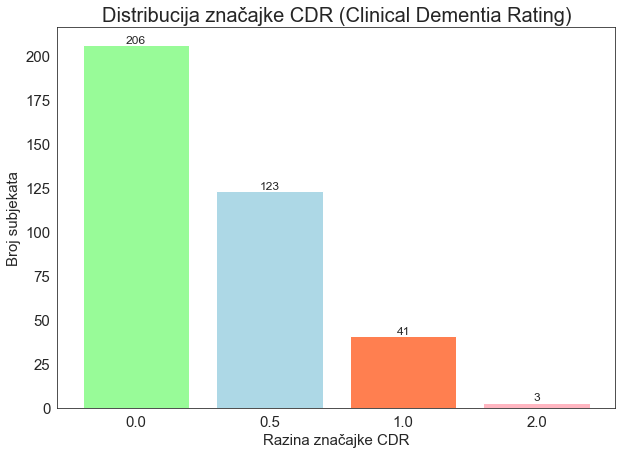

In [5]:
#distribucija značajke CDR
sns.set_style("white")
fig, ax = plt.subplots(figsize = (10, 7))
 
frekvencija = data.groupby('CDR').count().loc[:,'Subject ID'].values
razine = data.groupby('CDR').count().index.values
razine = [str(i) for i in razine]

bars = plt.bar(razine, frekvencija, color = ["palegreen", "lightblue", "coral","lightpink"])
ax.bar_label(bars,size = 12)
plt.xlabel("Razina značajke CDR")
plt.ylabel("Broj subjekata")
plt.title("Distribucija značajke CDR (Clinical Dementia Rating)")
ax.title.set_fontsize(20)
for item in ([ ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.show()



#print(data.CDR.value_counts())



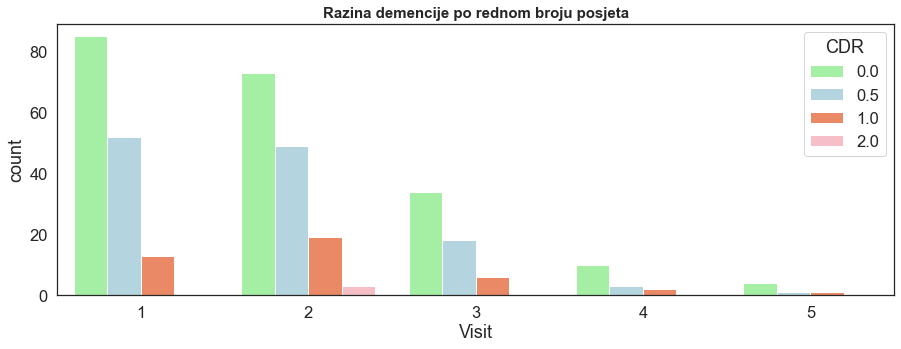

In [6]:

sns.set(font_scale=1.5)
sns.set_style("white")
fig = plt.figure(figsize = (15,5))
sns.countplot(data=data, x="Visit", hue="CDR",palette = ["palegreen", "lightblue", "coral","lightpink"]).set_title("Razina demencije po rednom broju posjeta",size = 15,weight = "bold");



Za CDR veći ili jednak od 0.5 smatra se da je osoba dementna. Od svih snimanja *206* ih nije pokazalo dementnost,
a samo *3 snimanja* su imala najvišu kategoriju demencije (2).


Pogledamo li razinu demencije po rednom broju posjeta može se primijetiti smanjenje nedementnih subjekata i porast demencije razine 1 u 2. posjetu (u odnosu na prvo snimanje) što znači da imamo dio subjekata koji su za vrijeme studije postali dementni (ili im se pogoršalo stanje).

## **DETEKCIJA STRŠEĆIH I NEDOSTAJUĆIH VRIJEDNOSTI**

Prije daljnje analize i vizualizacije značajki, htjela sam provjeriti ima li u podatkovnom skupu
stršećih i nedostajućih vrijednosti numeričkih i ordinalnih varijabli.
Broj outliera po značajki:
* **MR Delay** - 8 (izbačeni)
* **Age** - 0
* **EDUC** - 3 (iznadprosječno visokoobrazovani subjekti; izbačeni)
* **SES** - 7 (u cijelom skupu ima samo 7 pojedinaca s najvišom kategorijom SES-a; ostavljeni radi demografske raznolikosti)
* **MMSE** - 42 (ostavila sam ih jer ih je puno u odnosu na broj subjekata, svi su dementni što objašnjava niži rezultat od većine)
* **CDR** - 3 (ostavljeni kako bi u skupu imali i jako dementne pojedince)
* **eTIV** - 2 (izbačeni)
* **nWBV** - 0
* **ASF** - 1 (izbačen)
        
            
Nakon izbacivanja ostali su podatci za 359 snimanja.            

In [7]:
numericke = ['MR Delay', 'Age','EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
data2 = data.copy() #predikcije će se početno raditi na originalnom datasetu
def granice_za_outliere(data, col_name):
    q1 = data[col_name].quantile(0.25)
    q3 = data[col_name].quantile(0.75)
    iqr = q3-q1 #interkvartilni rang
    donja_granica  = q1 - 1.5*iqr
    gornja_granica = q3 + 1.5*iqr
    return donja_granica, gornja_granica

#for i in numericke:
  #donja, gornja = granice_za_outliere(data, i)
  #print(i)
  #df_out = data[(data[i] < donja) | (data[i] > gornja)]
  #print(data[i].mean())
  #print(df_out)
  #print(df_out.shape[0])
    
izbaci  = ['MR Delay', 'EDUC',  'eTIV', 'ASF']
for i in izbaci:
    donja, gornja = granice_za_outliere(data, i)
    data2 = data2[(data2[i] >= donja) & (data2[i] <= gornja)]
      


Klasifikacijski se modeli ne znaju nositi s nedostajućim vrijednostima zato ih je nužno detektirati.
Po detekciji one se mogu izbaciti ili se mogu interpolirati ili zamijeniti nekom mjerom centralne tendencije.
U podatkovnom skupu 2 varijable imaju nedostajuće vrijednosti:
*  **MMSE** - 2 nedostajuće vrijednosti, radi se o dementnim subjektima
* **SES** - 19 nedostajućih vrijednosti, radi se o dementnim subjektima

Valjana je pretpostavka da pojedinci s demencijom imaju niži rezultat na ovom testu pa će se te vrijednosti zamijeniti srednjom vrijednošću značajke MMSE za dementnu grupu. Značajka SES također ima niži medijan i mod (2) na cijelom skupu, nego za one s demencijom (medijan je 3, mod je 4) pa se primjerenim čini zamijeniti te nedostajuće vrijednosti s medijanom dementne grupe.

In [8]:

#nedostajuće vrijednosti
print(data2.isna().sum())
#data2[data2.isna().any(axis=1)]
mmse_D = data2[data2.Group == "Demented"]["MMSE"].mean()
mmse_all = data2["MMSE"].mean()
ses_all_median = data2["SES"].median()
ses_D_median = data2[data2.Group == "Demented"]["SES"].median()
print(f"Prosječan rezultat MMSE grupe dementnih: {mmse_D:.2f}")
print(f"Prosječan rezultat MMSE svih ispitanika: {mmse_all:.2f}")
print(f"Medijan socioekonomske kategorije svih ispitanika: {ses_all_median}")
print(f"Medijan socioekonomske kategorije grupe dementnih: {ses_D_median}")

Subject ID     0
Group          0
Visit          0
MR Delay       0
Gender         0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
dtype: int64
Prosječan rezultat MMSE grupe dementnih: 24.49
Prosječan rezultat MMSE svih ispitanika: 27.30
Medijan socioekonomske kategorije svih ispitanika: 2.0
Medijan socioekonomske kategorije grupe dementnih: 3.0


In [9]:

#traženje prikladne zamjene
#data2[data2['SES'].isna()]
#data2[data2['MMSE'].isna()]
#print(data2["SES"].median())
#print(data2["SES"].mode())
#print(data2[data2.Group == "Demented"]["SES"].median())
#print(data2[data2.Group == "Demented"]["SES"].mode())

data2.loc[data2.MMSE.isna(),'MMSE'] = mmse_D
data2.loc[data2.SES.isna(),'SES'] = ses_D_median
print(f"Preostalo zapisa: {data2.shape[0]}")

Preostalo zapisa: 359


## **VIZUALIZACIJA PODATAKA I DESKRIPTIVNA STATISTIKA**

Budući da se radi o podatcima iz longitudinalne studije, odlučila sam vizualizirati značajke i prikazati deskriptivnu statistiku za jedno snimanje kako značajke pacijenata koji su išli na više snimanja ne bi imale veću težinu. Odabrala sam analizirati prvo snimanje jer za njega imamo najviše podataka. Uvidom u deskriptivnu statistiku ovog podskupa i cijelog skupa nema značajne razlike u aritmetičkoj sredini. Ipak, za neke je značajke (poput spola) smislenije temeljiti hipoteze na podatcima s prvog snimanja.

Ovisno o tome jesu li subjekti dementni podijeljeni su u 3 grupe:
* **Demented**:  64 su imala od prvog skeniranja nadalje (uključivo 13 s ozbiljnijim stupnjem demencije, značajka CDR)
* **Nondemented**: 70 ispitanika nije imalo Alzheimer tijekom cijele studije
* **Converted**: 14 je ispitanika na prvom skeniranju nije imalo bolest, ali je kasnije postalo dementno


Dimenzije podataka za prvo snimanje: (148, 13)


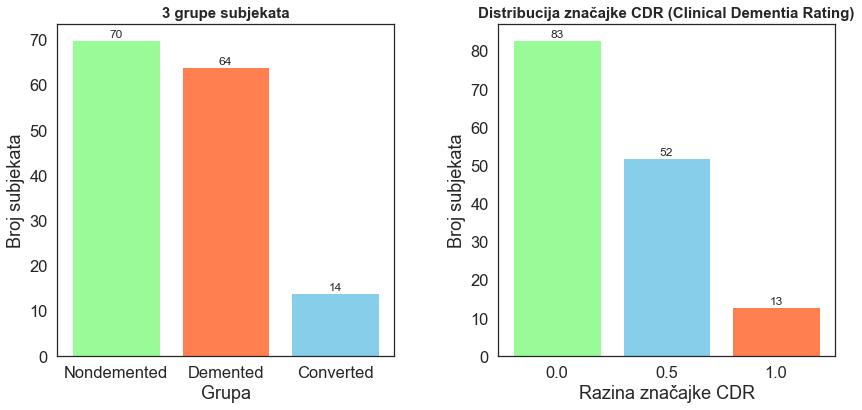

In [10]:

prvo_snimanje = data2[data2.Visit == 1]

print(f"Dimenzije podataka za prvo snimanje: {prvo_snimanje.shape}")

fig, (ax1,ax2) = plt.subplots(1,2,figsize = (13, 7))

grupe = prvo_snimanje.groupby('Group').count().loc[:,'Subject ID'].values

title_name = prvo_snimanje.groupby('Group').count().index.values

bars = ax1.bar(title_name[::-1], grupe[::-1],color = ["palegreen","coral","skyblue"])

ax1.bar_label(bars,size = 12)
ax1.set_xlabel("Grupa")
ax1.set_ylabel("Broj subjekata")
ax1.set_title("3 grupe subjekata", weight="bold")
ax1.title.set_fontsize(15)

 
frekvencija = prvo_snimanje.groupby('CDR').count().loc[:,'Subject ID'].values
razine = prvo_snimanje.groupby('CDR').count().index.values
razine = [str(i) for i in razine]

bars = ax2.bar(razine, frekvencija, color =["palegreen","skyblue","coral"])
ax2.bar_label(bars,size = 12)
ax2.set_xlabel("Razina značajke CDR")
ax2.set_ylabel("Broj subjekata")
ax2.set_title("Distribucija značajke CDR (Clinical Dementia Rating)",weight="bold")
ax2.title.set_fontsize(15)

plt.tight_layout(pad = 3.0)
plt.show()

Kako bih sažeto prikazala podatkovni skup iskoristila sam **osnovnu deskripitvnu statistiku** (minimalnu vrijednost, maksimalnu vrijednost, medijan, aritmetičku sredinu, standardnu devijaciju) i stekla prvi uvid u podatke. Za kategorijske varijable sam pogledala distribuciju pojedine kategorije.


In [11]:
prvo_snimanje.describe()
#data2.describe()

Visit  MR Delay         Age        EDUC         SES        MMSE  \
count  148.0     148.0  148.000000  148.000000  148.000000  148.000000   
mean     1.0       0.0   75.256757   14.479730    2.533784   27.554054   
std      0.0       0.0    7.409427    2.807835    1.102968    2.985871   
min      1.0       0.0   60.000000    6.000000    1.000000   17.000000   
25%      1.0       0.0   70.000000   12.000000    2.000000   26.000000   
50%      1.0       0.0   75.000000   14.000000    3.000000   29.000000   
75%      1.0       0.0   80.000000   16.000000    3.000000   30.000000   
max      1.0       0.0   96.000000   20.000000    5.000000   30.000000   

              CDR         eTIV        nWBV         ASF  
count  148.000000   148.000000  148.000000  148.000000  
mean     0.263514  1471.101351    0.736581    1.208514  
std      0.327046   170.670337    0.036438    0.136196  
min      0.000000  1123.000000    0.660000    0.897000  
25%      0.000000  1345.750000    0.710000    1.125000  
50%      0.000000  1450.000000    0.736500    1.210500  
75%      0.500000  1559.750000    0.758250    1.304250  
max      1.000000  1957.000000    0.837000    1.563000

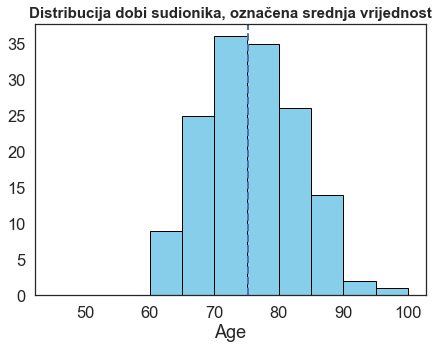

In [12]:
plt.figure(figsize = (7,5))
bins = [45,50,55,60,65,70,75,80,85,90,95,100]
plt.hist(prvo_snimanje.Age,bins = bins,edgecolor='black',color = "skyblue")
plt.xlabel('Age')
plt.axvline(prvo_snimanje.Age.mean(), color='b', linestyle='dashed', linewidth=2)
plt.title("Distribucija dobi sudionika, označena srednja vrijednost", size = 15, weight ="bold")

plt.show()

U ovom se članku koriste podatci iz longitudinalne studije provedene na 150 odraslih u dobi od 60 do 96 godina. Uklanjanjem stršećih vrijednosti ostali su podatci s prvog snimanja za 148 ljudi. 

Prosječna dob ispitanika je 75 godina. 

Medijan godina obrazovanja je 14 godina. 

Medijan na rezultatu MMSE je 29 bodova što jako visok rezultat - očekivano jer je samo 13 ispitanika imalo veću razinu demencije na prvom snimanju.

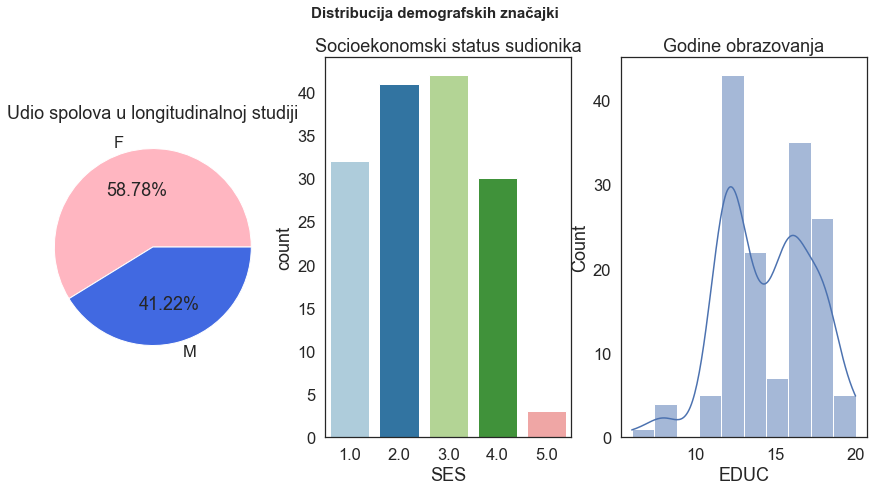

In [13]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (15, 7))
plt.suptitle ("Distribucija demografskih značajki",fontsize = 15, weight = "bold")

count_per_gender = prvo_snimanje.groupby('Gender').count().loc[:,'Visit'].values
gender = prvo_snimanje.groupby('Gender').count().index.values
percent = (count_per_gender/len(prvo_snimanje))*100

ax1.pie(percent, labels=gender, autopct='%.2f%%',colors = ["lightpink","royalblue"] )
ax1.set_title("Udio spolova u longitudinalnoj studiji")





sns.countplot(data=prvo_snimanje, x="SES",palette = "Paired", ax = ax2).set_title("Socioekonomski status sudionika");
sns.histplot(data=prvo_snimanje, x="EDUC", kde=True,ax = ax3).set_title("Godine obrazovanja");

U studiji je sudjelovalo 59% žena.

Među ispitanicima su većinom ljudi srednjeg socioekonomskog statusa: razina 2 i 3. Udio izrazito bogatih (razina 5) je zanemariv, a onih najniže razina ima 22%.

Distribucija godina obrazovanja je bimodalna, većina ispitanika se obrazovala više od 12 godina.

S obzirom da je cilj rada previdjeti Alzheimer, odlučila sam proučiti kakvav je utjecaj pojedinih varijabli na demenciju.

In [14]:
print(pd.crosstab(prvo_snimanje['Group'],prvo_snimanje['Gender']))
print(pd.crosstab(prvo_snimanje['Group'], prvo_snimanje['SES']))
print(pd.crosstab(prvo_snimanje['Group'], prvo_snimanje['CDR'],))

Gender        F   M
Group              
Converted    10   4
Demented     28  36
Nondemented  49  21
SES          1.0  2.0  3.0  4.0  5.0
Group                               
Converted      7    3    3    1    0
Demented      11   12   23   16    2
Nondemented   14   26   16   13    1
CDR          0.0  0.5  1.0
Group                     
Converted     13    1    0
Demented       0   51   13
Nondemented   70    0    0


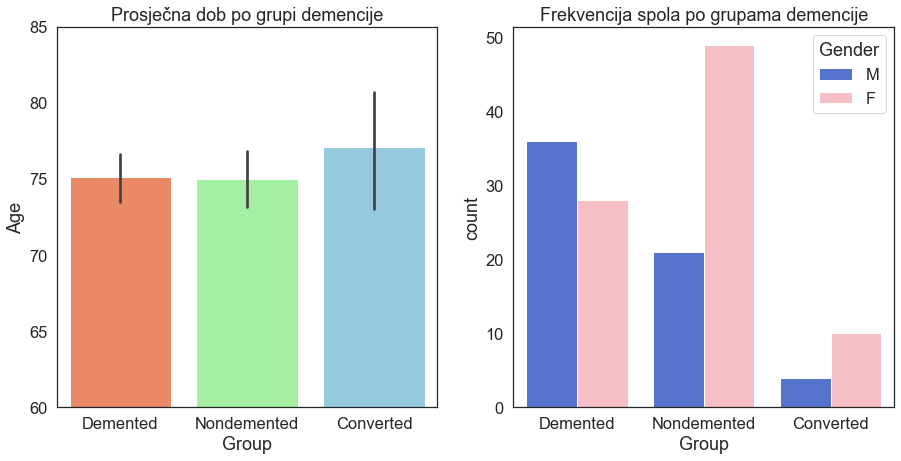

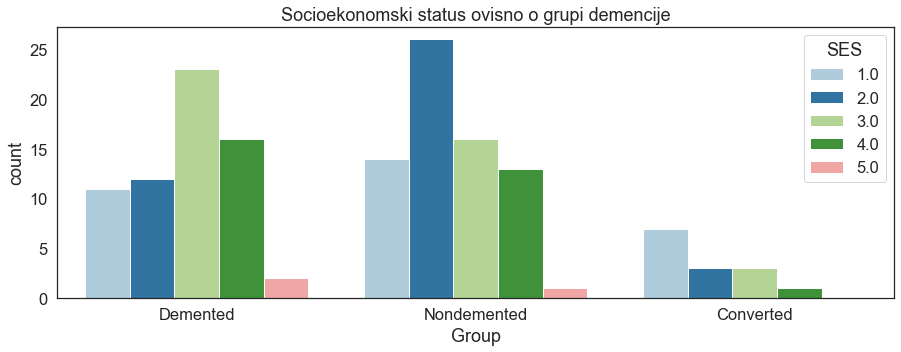

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15, 7))
ax1.set(ylim=(60,85))
bar = sns.barplot(
    data=prvo_snimanje, x="Group", y="Age", palette = ["coral","palegreen","skyblue"],
   ax = ax1)
bar.set_title ("Prosječna dob po grupi demencije");

sns.countplot(data=prvo_snimanje, x="Group", hue="Gender", ax = ax2,
              palette = ["royalblue","lightpink"]).set_title("Frekvencija spola po grupama demencije")

sns.color_palette("Set3", 5)
fig = plt.figure(figsize = (15,5))
sns.countplot(data=prvo_snimanje, x="Group", hue="SES",palette = "Paired").set_title("Socioekonomski status ovisno o grupi demencije");

Prosječna dob se ne razlikuje značajno među ispitanicama na prvom snimanju. Oni koji su u narednom razdoblju postali dementni (grupa Converted) su nešto stariji - hipoteza: Alzheimer se javlja u starijoj dobi.

Među dementnima (od početka) je više muškaraca. Među onima koji su postali dementni je više žena.

Među dementnima prevladavaju oni više razine obrazovanja (od 3 nadalje), dok među onima koji nisu dementni prevladava 2. kategorija. U grupi Converted prevladava prva kategorija.

Za spol i socioekonomski status sam htjela provjeriti jesu li nezavisni s grupom demencije. Za to mogu iskoristiti neparametarski statistički test *chi* square test. Nulta hipoteza je da su značajke nezavisne.
Pokazalo se da možemo odbaciti H0 -> spol i grupa demencije nisu nezavisni.
Za socioekonomski status se pokazalo da ne možemo odbaciti H0, iako je p vrijednost 0.055 pa tu treba biti oprezan s zaključcima.

In [16]:
spol_demencija = pd.crosstab(prvo_snimanje['Group'],prvo_snimanje['Gender'])
stat, p, dof, expected = chi2_contingency(spol_demencija)
alpha = 0.05
print("p value is " + str(round(p,3)))
if p <= alpha:
    print('Značajke (spol i demencija) su zavisne.')
else:
    print('Značajke (spol i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)')
    
ses_demencija = pd.crosstab(prvo_snimanje['Group'],prvo_snimanje['SES'])
stat, p, dof, expected = chi2_contingency(ses_demencija)
#print(ses_demencija)

print("p value is " + str(round(p,3)))
if p <= alpha:
    print('Značajke (SES i demencija) su zavisne.')
else:
    print('Značajke (SES i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)')

p value is 0.005
Značajke (spol i demencija) su zavisne.
p value is 0.055
Značajke (SES i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)


Paralelnim koordinatama sam prikazala kako se odnose značajke MMSE, CDR, nWBV, Age i eTIV. Jasno se vidi da osobe s demencijom imaju manju značajku nWBV koja opisuje volumen mozga. Za dob i tu značajku bismo mogli reći da su obrnuto proporcionalne. Za značajku MMSE i CDR bismo također mogli reći da su obrnuto proporcionalne.

In [17]:
import plotly.express as px
X_tmp = prvo_snimanje.loc[:, ['MMSE','CDR','nWBV','Age','eTIV']]
fig = px.parallel_coordinates(X_tmp, color="CDR", labels={"MMSE": "MMSE",
                  "Age": "Age", "CDR": "CDR",
                  "eTIV": "eTIV", "nWBV": "nWBV", },
                    color_continuous_scale=px.colors.diverging.Tropic, range_color=[0,1])
fig.show()

Zanimalo me kako se mijenja rezultat na MMSE ovisno o spolu i razini demencije.

Po razinama demencije nema razlike u spolu, ali se rezultat značajno smanjuje kako raste razina demencije.

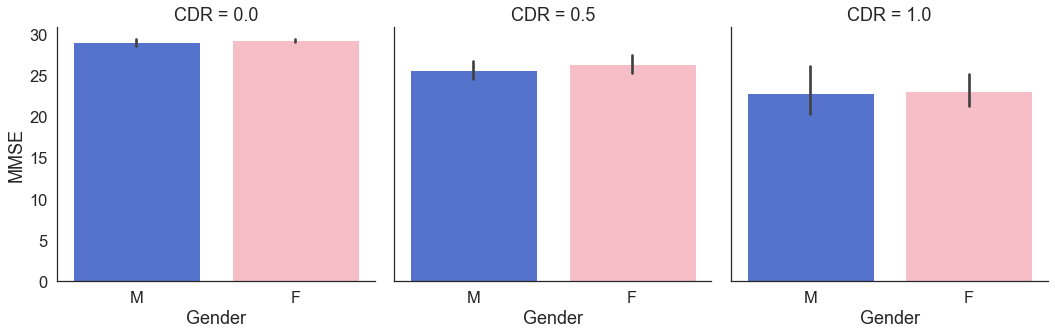

In [18]:

sns.catplot(
    data=prvo_snimanje, x="Gender", y="MMSE", col="CDR",kind = "bar", 
    palette = ["royalblue","lightpink"]
)



Napravila sam binarnu značajku Demented (prema značajci CDR) kako bismo znali je li osoba dementna u trenutku snimanja.

In [19]:
#je li na prvom snimanju već imao demenciju

def demented(row):
    if row.CDR >= 0.5:
        return "Demented"
    else:
        return "Nondemented"
 
prvo_snimanje.loc[:,'Demention'] = prvo_snimanje.apply(lambda row: demented(row), axis=1)


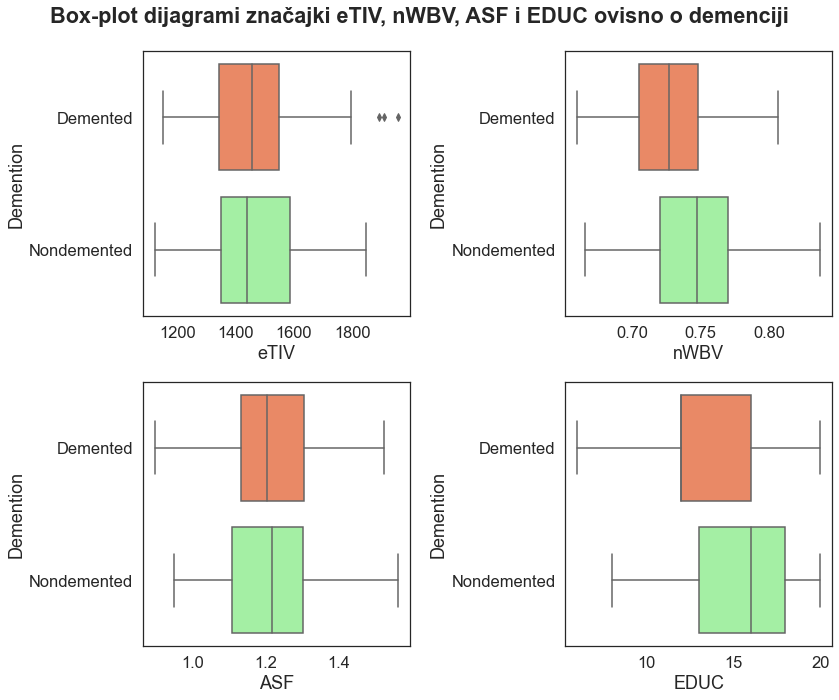

In [20]:

fig = plt.figure(figsize = (12,10))
fig.suptitle("Box-plot dijagrami značajki eTIV, nWBV, ASF i EDUC ovisno o demenciji",weight = "bold")

ax1 = fig.add_subplot(221)
sns.boxplot(data=prvo_snimanje, x="eTIV", y="Demention",ax = ax1,palette = ["coral","palegreen"])
ax2 = fig.add_subplot(222)
sns.boxplot(data=prvo_snimanje, x="nWBV", y="Demention",ax = ax2, palette = ["coral","palegreen"])
ax3 = fig.add_subplot(223)
sns.boxplot(data=prvo_snimanje, x="ASF", y="Demention",ax = ax3, palette = ["coral","palegreen"])
ax3 = fig.add_subplot(224)
sns.boxplot(data=prvo_snimanje, x="EDUC", y="Demention",ax = ax3, palette = ["coral","palegreen"])
plt.tight_layout()


Distribucija značajke eTIV je slična za obje skupine. 
Normalizirani volumen mozga je značajno veći za nedementne pojednce.
Može se primjetiti da za ASF nema značajne razlike ovisno o demenciji. 
Primjeti se da je gornji kvartil (i medijan) godina obrazovanja veći za one koji nisu dementnti.

In [21]:
# Shapiro-Wilk test normalnosti
from scipy.stats import shapiro
def normal(znacajka):
    print(f"Normalnost značajke {znacajke} za (ne)dementne:")
    dementni = prvo_snimanje[prvo_snimanje.Demention == "Demented"][znacajka]
    nedementni = prvo_snimanje[prvo_snimanje.Demention == "Nondemented"][znacajka]
    stat, p = shapiro(nedementni)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Gaussian')
    else:
        print('not Gaussian')
    stat, p = shapiro(dementni)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Gaussian')
    else:
        print('not Gaussian')
    
#znacajke = ["eTIV", "nWBV", "ASF", "EDUC","Age"]
#for i in znacajke:
#    normal(i)
def ttest(znacajka):
    

    dementni = prvo_snimanje[prvo_snimanje.Demention == "Demented"][znacajka]
    nedementni = prvo_snimanje[prvo_snimanje.Demention == "Nondemented"][znacajka]

    statistic, p  = stats.ttest_ind(dementni, nedementni)
    print(f"p-vrijednost: {p:.5f}")
    if p > 0.5:
        print(f"Srednje vrijednosti uzoraka za značajku {znacajka} su jednake.")
    else:
        print(f"Srednje vrijednosti uzoraka za značajku {znacajka} nisu jednake.")
        
znacajke = ["eTIV", "nWBV", "ASF", "EDUC"]
for i in znacajke:
    ttest(i)

p-vrijednost: 0.86323
Srednje vrijednosti uzoraka za značajku eTIV su jednake.
p-vrijednost: 0.00043
Srednje vrijednosti uzoraka za značajku nWBV nisu jednake.
p-vrijednost: 0.86322
Srednje vrijednosti uzoraka za značajku ASF su jednake.
p-vrijednost: 0.00150
Srednje vrijednosti uzoraka za značajku EDUC nisu jednake.


S obzirom da su značajke ASF, nWBV i eTIV približno normalno distribuirane (po Shapiro-Wilk testu), mogla sam t-testom provjeriti razlikuju li se srednje vrijednosti tih značaji za grupe demencije.
Doista, srednje vrijednosti za značajke eTIV i ASF su jednake i za dementnu i nedementnu grupu.
Za značajku nWBV nisu jednake, kao ni za značajku EDUC (iako ta značajka nije normalno distribuirna).

      AgeCategory       CDR
0  (59.964, 67.2]  0.250000
1    (67.2, 74.4]  0.270833
2    (74.4, 81.6]  0.270000
3    (81.6, 88.8]  0.261905
4    (88.8, 96.0]  0.214286
p-vrijednost: 0.66137
Srednje vrijednosti uzoraka za značajku Age su jednake.


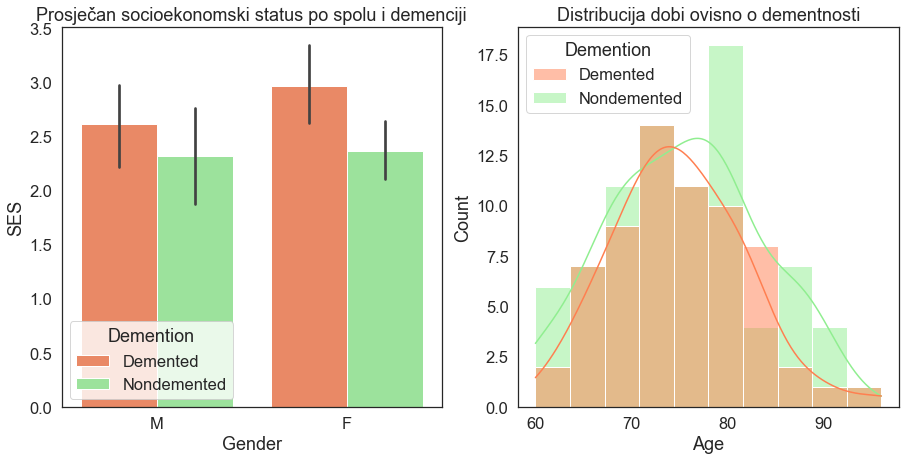

In [22]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (15, 7))

sns.barplot(
    data=prvo_snimanje, x="Gender", y="SES", hue = "Demention", ax = ax1,
    palette = ["coral","lightgreen"]).set_title("Prosječan socioekonomski status po spolu i demenciji")
sns.histplot(data= prvo_snimanje, x="Age", kde=True, hue = "Demention", ax = ax2, palette = ["coral","lightgreen"]).set_title("Distribucija dobi ovisno o dementnosti")
prvo_snimanje['AgeCategory'] = pd.cut(prvo_snimanje['Age'], 5)
# prikažimo ovisnost s demencijom
print(prvo_snimanje[['AgeCategory', 'CDR']].groupby(by='AgeCategory',as_index=False).mean().sort_values(by='AgeCategory', ascending=True))
ttest("Age")

Neovisno o spolu dementni imaju prosječno viši socioekonomski status.

Na prvom je snimanju među dementnima bilo najviše 70godišnjaka, a distribucije dobi nisu značajno različite. Prema t-testu srednje vrijednosti dementnih i nedementnih sudionika su jednake.

Odlučila sam prikazati 3 scatterplota. Pomoću njih možemo vidjeti postoji li veza između odabrane 2 značajke te između njih i demencije.

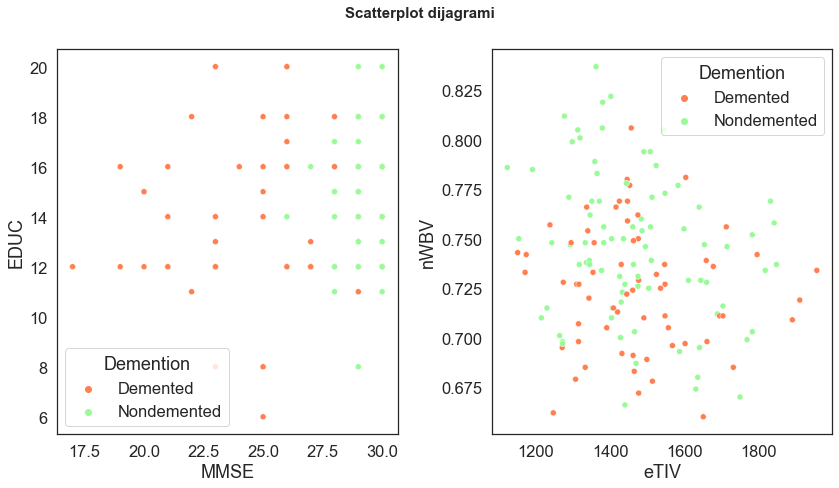

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 7))
plt.suptitle ("Scatterplot dijagrami",fontsize = 15, weight = "bold")
#MMSE vs EDUC

sns.scatterplot( x="MMSE", y="EDUC", ax = ax1, data=prvo_snimanje,  hue='Demention',palette = ["coral","palegreen"])

#eTIV vs nWBV

sns.scatterplot( x="eTIV", y="nWBV", ax = ax2, data=prvo_snimanje, hue='Demention',palette = ["coral","palegreen"])
plt.tight_layout()



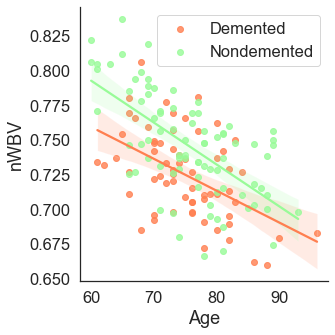

In [24]:
#nWBV vs Age
sns.lmplot( x="Age", y="nWBV", data=prvo_snimanje,  hue='Demention',legend =False,palette = ["coral","palegreen"])
plt.legend(loc='best')
plt.show()


Opažanja:
* dementni pojedenici imaju značajno lošiji rezultat na MMSE (neovisno o godinama obrazovanja)
* značajka nWBV je prosječno manja za dementne pojedince, čine se da nema veze između te značajke i eTIV
* s godinama se nWBV smanjuje

Zanimljivo mi se činilo proučiti kako se mijenjaju (po posjetima) pojedine značajke za grupu Converted jer se kod njih demencija tek razvila za vrijeme istraživanja. Prikazala sam značajke MMSE, eTIV, nWBV i dob po posjetima za tu grupu. 

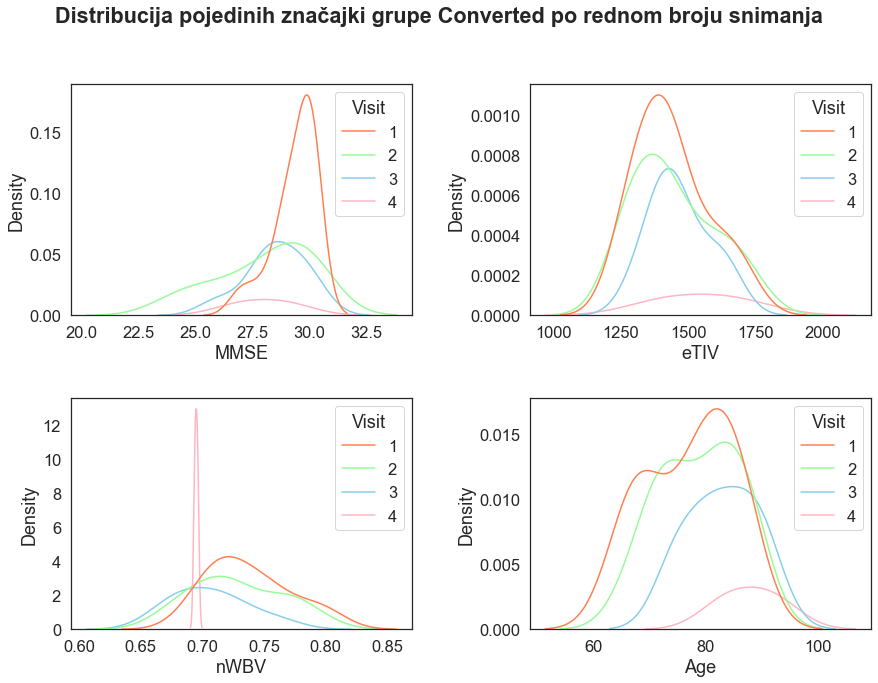

In [25]:
fig, ax = plt.subplots(2,2,figsize = (13, 10))
plt.suptitle("Distribucija pojedinih značajki grupe Converted po rednom broju snimanja", weight ="bold")
sns.kdeplot(
    data=data2[data2.Group == "Converted"], x="MMSE", hue="Visit",palette = ["coral","palegreen","skyblue","lightpink"],
    ax = ax[0,0])

sns.kdeplot(
    data=data2[data2.Group == "Converted"], x="eTIV", hue="Visit",palette = ["coral","palegreen","skyblue","lightpink"],
        ax = ax[0,1])

sns.kdeplot(
    data=data2[data2.Group == "Converted"], x="nWBV", hue="Visit", palette = ["coral","palegreen","skyblue","lightpink"],
    ax = ax[1,0])

sns.kdeplot(
    data=data2[data2.Group == "Converted"], x="Age", hue="Visit", palette = ["coral","palegreen","skyblue","lightpink"],
    ax = ax[1,1]
)

plt.tight_layout(pad = 2.0)

Budući da se radi o longitudinalnom istraživanju, sudionici su očekivano prosječno stariji u odnosu na prvi posjet.

Može se primijetiti da se MMSE rezultat pogoršava po rednom broju posjeta. 
Za eTIV nema značajne razlike u distribuciji, minimalan porast.
Za normalizirani volumen mozga se jasno vidi da se smanjuje u odnosu na prvi posjet. Ovo potvrđuje da je Alzheimer progresivna degenerativna bolest.

Prije treniranja modela važno je bilo provesti eksploratornu analizu podatkovnog skupa. Već se vizualnom inspekcijom mogu zaključiti koje bi značajke bile dobri prediktori bolesti.

Provjerila sam ima li korelacije pojedinih značajki i izlazne varijable (Demention).
Korisno je provjeriti i ima li korelacije među pojedinim značajkama kako bi izbjegli multikoreliranost.

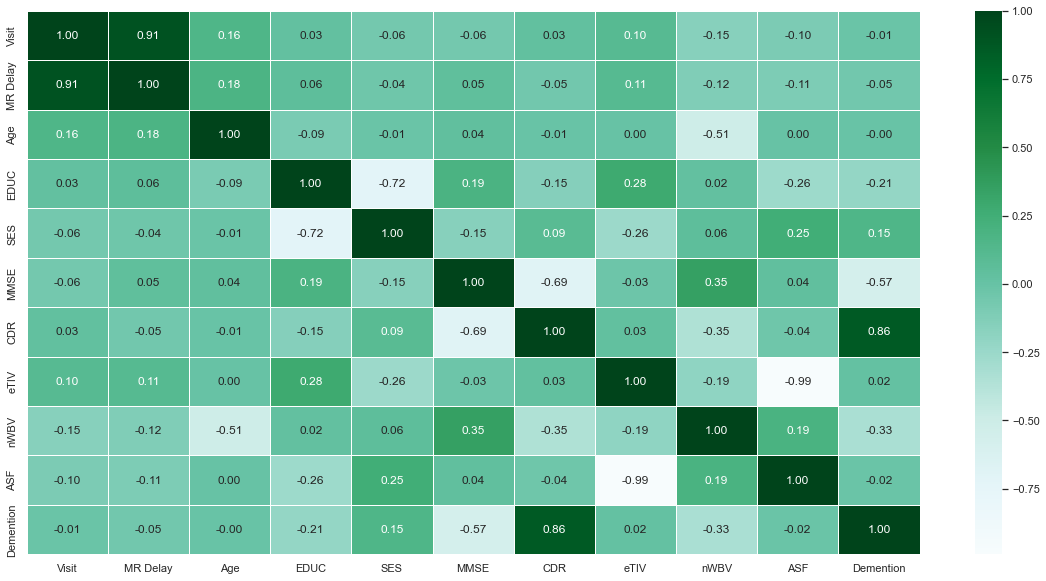

In [27]:
data2.loc[:,'Demention'] = data2.apply(lambda row: demented(row), axis=1)
data2.loc[data2['Demention'] == "Demented", 'Demention'] = 1
data2.loc[data2['Demention'] == "Nondemented", 'Demention'] = 0
data2["Demention"] = pd.to_numeric(data2["Demention"])

data_numeric = data2.loc[:,~data2.columns.isin(['Subject ID',"Group",'Gender'])]
sns.set(rc={'figure.figsize':(20,10)})
sns.heatmap(data_numeric.corr(), annot=True, fmt=".2f", cmap="BuGn", linewidths=.5)
plt.show()

Postoji jaka korelacija između broja posjeta i MRDelay, a gotovo nikakva između tih varijabli i izlazne pa se te varijable mogu izbaciti iz modela. 

Postoji nezanemariva negativna korelacija između socioekonomskog statusa i godina obrazovanja.

Postoji nezanemariva negativna korelacija između MMSE i CDR koji se već po vizualizacijama pokazao kao dobar prediktor. Također, nWBV je očito dobar prediktor.

Postoji izrazito jaka negativna korelacija (-0.99) između faktora ASF i eTIV, ali ni jedan od njih se (na prvi pogled) ne čini korisnim za klasifikaciju. Autori članka su odlučili koristi eTIV, a onda razumljivo njemu jako kolerirani ASF nisu.


In [26]:
# inicijalizacija enkodera - M - 1, F - 0

le = LabelEncoder()
le.fit(data.loc[:,'Gender'])
data.loc[:,'Gender'] = le.transform(data.loc[:,'Gender'])


## **REPLIKACIJA REZULTATA**
U članku je također provedena eksploratorna analiza: autori su proučili koje bi značajke mogle biti dobri prediktori za odrediti ima li osoba Alzheimer. Iz njihovih rezultata se vidi da su radili binarnu klasifikaciju (je li osoba dementna), a ciljna varijabla im je bila CDR koja originalno ima 4 vrijednosti. Odlučila sam da *izlazna varijabla* bude Demention: 0 ("Nondemented") i 1 ("Demented"). Tu sam značajku napravila prema značajci CDR kako bi se znalo ima li osoba Alzheimer (ukoliko je CDR >= 0.5, osoba je oboljela).

U članku se navodi da su nedostajuće vrijednosti zamjenjenje medijanom, a stršeće vrijednosti se ne spominju (zadržane su) pa ću i ja tako nastaviti, a u završnoj se fazi mogu isprobati modeli s ranije predloženim preinakama.
Od metoda za **odabir značajki** (engl. feature selection) spominju se koeficijent korelacije, informacijska dobit (engl. Information gain) i *chi* kvadrat test.

Provjera nezavisnosti kategorijskih varijabli provodi se *chi* kvadrat testom. Već sam pri eksploratornoj analizi pokazala da (na razini prvog snimanja) postoji zavisnost između dementnosti i spola. Ponovila sam testiranje na cijelom podatkovnom skupu za kategorijske varijable (Gender, SES, Visit). Pokazalo se da su značajke Geneder i SES potencijalno dobri prediktori, a da Visit možemo isključiti iz modela za predikciju.

Prema matrici korelacije pretpostavljam sljedeće:
* **MMSE** je značajan prediktor (postoji nezanemariva linearna ovisnost između te varijable i varijable CDR)
* značajke MRDelay i Visit su zanemarive
* **nWBV** bi mogao biti dobar prediktor
* značajke eTIV i ASF su izrazito negativno korelirane pa nije poželjno koristiti obje u modelu

Pri treniranju modela stabla odluke i njihova proširenja slučajnih šuma iskoristila sam informacijsku dobit kako bih odredila po kojim je značajkama najbolje granati stablo - to su one po čijem se grananju entropija najviše smanjuje.

Prema članku oni su u modelu zadržali sljedećih 7 značajki: Gender, Age, EDUC, SES, MMSE, eTIV i nWBV. Mogu primijetiti da su zadržali gotovo sve značajke.

Provjerila sam koje značajke dobili metodom selekcije značajki (mutual information). Ukoliko tražimo 4 značajke, preporučuju se: MMSE, eTIV, nWBV i ASF (ponekad EDUC). Poželjno bi bilo provjeriti utječe li smanjivanje broja korištenih značajki na točnost predikcije. Naime, modeli s manje značajki su bolji jer su interpretabilniji, brže se uče i primjenjuju. To posebno dolazi do izraza pri skupovima podataka s velikim broje značajki (što ovaj nije).

In [27]:
mmse_all = data["MMSE"].median()
ses_all_median = data["SES"].median()
data.loc[data.MMSE.isna(),'MMSE'] = mmse_all
data.loc[data.SES.isna(),'SES'] = ses_all_median

In [28]:
spol_demencija = pd.crosstab(data['Group'],data['Gender'])
stat, p, dof, expected = chi2_contingency(spol_demencija)
alpha = 0.05
print("p value is " + str(round(p,3)))
if p <= alpha:
    print('Značajke (spol i demencija) su zavisne.')
else:
    print('Značajke (spol i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)')
    
ses_demencija = pd.crosstab(data['Group'],data['SES'])
stat, p, dof, expected = chi2_contingency(ses_demencija)
#print(ses_demencija)

print("p value is " + str(round(p,3)))
if p <= alpha:
    print('Značajke (SES i demencija) su zavisne.')
else:
    print('Značajke (SES i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)')
    
visit_demencija = pd.crosstab(data['Group'],data['Visit'])
stat, p, dof, expected = chi2_contingency(visit_demencija)
#print(visit_demencija)

print("p value is " + str(round(p,3)))
if p <= alpha:
    print('Značajke (Visit i demencija) su zavisne.')
else:
    print('Značajke (Visit i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)')

p value is 0.0
Značajke (spol i demencija) su zavisne.
p value is 0.0
Značajke (SES i demencija) su zavisne.
p value is 0.339
Značajke (Visit i demencija) su nezavisne. (ne možemo odbaciti H0 na ovoj razini značajnosti)


In [29]:
data.loc[:,'Demention'] = data.apply(lambda row: demented(row), axis=1)
data.loc[data['Demention'] == "Demented", 'Demention'] = 1
data.loc[data['Demention'] == "Nondemented", 'Demention'] = 0
data["Demention"] = pd.to_numeric(data["Demention"])

kbest = SelectKBest(mutual_info_classif, k=4)

y = data.loc[:, 'Demention']
X = data.loc[:,~data.columns.isin(['Subject ID',"Demention","Group", "CDR"])]

#scaler = StandardScaler() #skaliranje nema utjecaja za 4 značajke
#data_t = scaler.fit_transform(X)
kbest.fit(X, y)
print(f"Najbolji prediktori po kriteriju mutual information: {kbest.get_feature_names_out(X.columns.values)}")


Najbolji prediktori po kriteriju mutual information: ['MMSE' 'eTIV' 'nWBV' 'ASF']


U članku se navodi da su podatci podijeljeni u skup za učenje i skup za testiranje u omjeru **80:20**. Iako se to ne navodi u članku, pri toj podjeli treba paziti kako isti subjekti ne bi bili u skupu za učenje i u skupu za testiranje. Cilj nam je dobiti modele koji što bolje generaliziraju pa sam tu podjelu napravila tako da su subjekti i njihovi posjeti (ukoliko ih ima više jer se radi o longitudinalnoj studiji) ili u skupu za učenje ili u skupu za treniranje.

U članku se navodi da je pri treniranju modela korištena peterostruka unakrsna validacija (engl. 5-fold cross validation) kako bi se optimirali parametri modela. Točnost dobivenog modela odredili su **desetorostrukom unakrsnom validacijom**. Skup za testiranje služi za konačnu evaluaciju i usporedbu klasifikatora.

Ovakva validacija modela dobro je prikazana na sljedećoj slici preuzetoj sa *scikit-learn* dokumentacije (https://scikit-learn.org/stable/modules/cross_validation.html).
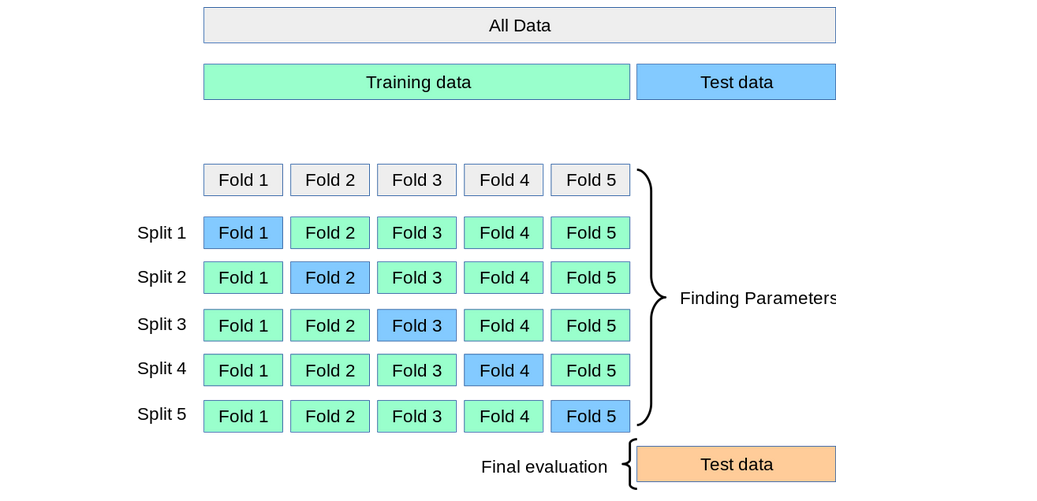

In [30]:

subjects = data["Subject ID"].unique()
subjects_train, subjects_test = train_test_split(subjects, test_size=0.2, random_state = 8)
train_df = data[data["Subject ID"].isin(subjects_train)]
test_df = data[data["Subject ID"].isin(subjects_test)]
#print(train_df.shape)
train_Y = train_df.loc[:, 'Demention']
train_X = train_df.loc[:,data.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
test_Y = test_df.loc[:, 'Demention']
test_X = test_df.loc[:,data.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
#print(train_df.Demention.value_counts())


## STABLA ODLUKA (engl. Decision Tree)
Stablo odluke je neparametarski klasifikator koji se može pokazati kao jako dobar ukoliko postoji jaka veza između prediktora i izlazne varijable. Problem kod ovog klasifikatora je potencijalna prenaučenost (izgradnja predubokog stabla), koja se rješava primjenom klasifikatora slučajnih šuma (engl. Random Forest) koji uči na podskupovima podatkovnog skupa i tako gradi više stabala odluka pa se konačna prediktivna odluka temelji na prosjeku odluka pojedinih stabala.

U članku nije opisana optimizacija hiperparametara pa sam ja isprobala broj razina stabala (od 2 do 7) i broj značajki koje se razmatraju pri grananju stabla (od 1 do 7). Hiperparametri su odabrani unakrsnom provjerom. Za *dubinu stabla* sam odabrala 2, a za *broj značajki* koje razmatra pri grananju 6. Kao kriterij podjele koristila sam "entropy" jer u članku spominju informacijsku dobit kao mjeru za odabir značajki. Kako ne bismo dobili prenaučen model nije dobro da stablo bude preduboko, niti da se razmatraju sve značajke pri grananju. Kao najvažnija značajka pri izgradji stabla pokazala se *MMSE*, gotovo da samo na temelju nje možemo reći je li osoba dementna s točnošću od 80%.

In [31]:
max_depth = [i for i in range(1,8)]
max_features = [i for i in range(1,8)]
accuracy = 0
best_combination = [max_depth[0],max_features[0]]

groups = np.array(train_df["Subject ID"])
group_kfold = GroupKFold(n_splits= 5)

for d in max_depth:
    for f in max_features:
        scores_acc = []
        for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

            train = train_df[train_df["Subject ID"].isin(groups[train_index])]
    
            train_x1 = train.loc[:,train.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
            train_y1 = train.loc[:,"Demention"]
            test = train_df[train_df["Subject ID"].isin(groups[test_index])]

            test_x1 = test.loc[:,test.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
            test_y1 = test.loc[:,"Demention"]
    

    
            clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = d, max_features = f)
            clf.fit(train_x1,train_y1)
    
            dt_predictions = clf.predict(test_x1)
 
            dt_accuracy = accuracy_score(test_y1,dt_predictions)
            
            scores_acc.append(dt_accuracy)
        if (np.array(scores_acc).mean())> accuracy:
            accuracy = np.array(scores_acc).mean()
            best_combination = [d,f]
        #print(d,f,np.array(scores_acc).mean())
        
print(f"Najbolja kombinacija hiperparametara je: maxdepth: {best_combination[0]} i max_features: {best_combination[1]}")
         

Najbolja kombinacija hiperparametara je: maxdepth: 1 i max_features: 6


In [32]:

groups = np.array(train_df["Subject ID"])
group_kfold = GroupKFold(n_splits= 10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["Subject ID"].isin(groups[train_index])]
    
    train_x1 = train.loc[:,train.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    train_y1 = train.loc[:,"Demention"]
    test = train_df[train_df["Subject ID"].isin(groups[test_index])]

    test_x1 = test.loc[:,test.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    test_y1 = test.loc[:,"Demention"]
    

    
    clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 2, max_features = 6, random_state = 42)
    clf.fit(train_x1,train_y1)
    
    dt_predictions = clf.predict(test_x1)
 
    dt_accuracy = accuracy_score(test_y1,dt_predictions)
    dt_precision = precision_score(test_y1,dt_predictions)
    dt_recall = recall_score(test_y1,dt_predictions)
    dt_f1 = f1_score(test_y1,dt_predictions)
    scores_accuracy.append(dt_accuracy)
    scores_precision.append(dt_precision)
    scores_recall.append(dt_recall)
    scores_f1.append(dt_f1)
    #print(clf.feature_importances_)

average_accuracy_dt = (np.array(scores_accuracy)).mean()
average_precision_dt = (np.array(scores_precision)).mean()
average_recall_dt = (np.array(scores_recall)).mean()
average_f1_dt = (np.array(scores_f1)).mean()

print("MODEL STABLA ODLUKA - 10kfold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_dt:.3f}")
print(f"Prosječna točnost (precision): {average_precision_dt:.3f}")
print(f"Prosječna točnost (recall): {average_recall_dt:.3f}")
print(f"Prosječna točnost (f1): {average_f1_dt:.3f}")



MODEL STABLA ODLUKA - 10kfold unakrsna validacija
Prosječna točnost (accuracy): 0.803
Prosječna točnost (precision): 0.898
Prosječna točnost (recall): 0.591
Prosječna točnost (f1): 0.698


## SLUČAJNE ŠUME (engl. Random Forest)

Model slučajne šume je primjer ansambla - predikcija se donosi na temelju pojedinačnih predikcija stabala odluka (engl. bagging) nastalih na temelju podskupa skupa za učenje. Konačna predikcija je većinska klasa. Ovaj model bi trebao bolje generalizirati od 1 stabla odluke. 

Unakrsnom provjerom sam provjerila adekvatan broj stabala za predikciju: 100 (to je pretpostavljena vrijednost implementiranog ansambla u *sci-kit learnu*). Vrijednosti 2 za hiperparametar max_depth i 6 za max_features se čine optimalnima. Zbog brzine i sličnosti u rezultatu u nastavku ću koristiti funkciju *cross_val_score* za određivanje hiperparamatera. 

In [33]:

number_of_trees = [1,25,50,75,100,125,150,175,200,225]
for i in number_of_trees:
    print("broj stabala: " + str(i))
    clf = RandomForestClassifier(criterion = "entropy", n_estimators = i)
    
    scores = cross_val_score(clf, train_X, train_Y, cv=5)
    score = scores.mean()
    print(f"točnost: {score}")
    


broj stabala: 1
točnost: 0.7259887005649717
broj stabala: 25
točnost: 0.7726553672316384
broj stabala: 50
točnost: 0.779322033898305
broj stabala: 75
točnost: 0.7994350282485876
broj stabala: 100
točnost: 0.7694915254237288
broj stabala: 125
točnost: 0.8027683615819209
broj stabala: 150
točnost: 0.7927683615819209
broj stabala: 175
točnost: 0.7961581920903955
broj stabala: 200
točnost: 0.7961581920903955
broj stabala: 225
točnost: 0.7961016949152543


In [35]:
max_depth = [i for i in range(1,8)]
max_features = [i for i in range(1,8)]
accuracy = 0
best_combination = [max_depth[0],max_features[0]]

groups = np.array(train_df["Subject ID"])
group_kfold = GroupKFold(n_splits= 5)

for d in max_depth:
    for f in max_features:
        scores_acc = []
        for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

            train = train_df[train_df["Subject ID"].isin(groups[train_index])]
    
            train_x1 = train.loc[:,train.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
            train_y1 = train.loc[:,"Demention"]
            test = train_df[train_df["Subject ID"].isin(groups[test_index])]

            test_x1 = test.loc[:,test.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
            test_y1 = test.loc[:,"Demention"]
    
            clf = RandomForestClassifier(criterion = "entropy", max_depth = d, max_features = f)
            clf.fit(train_x1,train_y1)
    
            dt_predictions = clf.predict(test_x1)
            dt_accuracy = accuracy_score(test_y1,dt_predictions)
            scores_acc.append(dt_accuracy)
        if (np.array(scores_acc).mean())> accuracy:
            accuracy = np.array(scores_acc).mean()
            best_combination = [d,f]
        print(d,f,np.array(scores_acc).mean())
        
print(f"Najbolja kombinacija hiperparametara je: maxdepth: {best_combination[0]} i max_features: {best_combination[1]}")

1 1 0.6523163841807909
1 2 0.7859887005649718
1 3 0.8061581920903954
1 4 0.8061581920903954
1 5 0.8094915254237289
1 6 0.8128248587570621
1 7 0.8128248587570621
2 1 0.7426553672316384
2 2 0.8127683615819208
2 3 0.8094915254237289
2 4 0.8094915254237289
2 5 0.8128248587570621
2 6 0.8128248587570621
2 7 0.8094915254237289
3 1 0.7494350282485877
3 2 0.7861581920903954
3 3 0.7828248587570621
3 4 0.8094915254237289
3 5 0.8094915254237289
3 6 0.8128248587570621
3 7 0.8161581920903955
4 1 0.7459887005649718
4 2 0.76954802259887
4 3 0.7827683615819209
4 4 0.7761581920903955
4 5 0.7761581920903955
4 6 0.7727683615819209
4 7 0.7761016949152542
5 1 0.7493785310734464
5 2 0.7728813559322034
5 3 0.7662146892655367
5 4 0.7694915254237288
5 5 0.7661581920903955
5 6 0.7561016949152541
5 7 0.7561581920903955
6 1 0.736045197740113
6 2 0.7728248587570622
6 3 0.7662146892655367
6 4 0.7628813559322034
6 5 0.7562146892655368
6 6 0.7594915254237289
6 7 0.75954802259887
7 1 0.7661016949152543
7 2 0.7695480225

In [36]:
groups = np.array(train_df["Subject ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["Subject ID"].isin(groups[train_index])]
    
    train_x2 = train.loc[:,train.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    train_y2 = train.loc[:,"Demention"]
    test = train_df[train_df["Subject ID"].isin(groups[test_index])]

    test_x2 = test.loc[:,test.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    test_y2 = test.loc[:,"Demention"]
    

    
    clf = RandomForestClassifier(criterion = "entropy", max_depth = 2, max_features = 6, random_state = 42)
    clf.fit(train_x2,train_y2)
    
    rf_predictions = clf.predict(test_x2)

    rf_accuracy = accuracy_score(test_y2,rf_predictions)
    rf_precision = precision_score(test_y2,rf_predictions)
    rf_recall = recall_score(test_y2,rf_predictions)
    rf_f1 = f1_score(test_y2,rf_predictions)
    scores_accuracy.append(rf_accuracy)
    scores_precision.append(rf_precision)
    scores_recall.append(rf_recall)
    scores_f1.append(rf_f1)

average_accuracy_rf = (np.array(scores_accuracy)).mean()
average_precision_rf = (np.array(scores_precision)).mean()
average_recall_rf = (np.array(scores_recall)).mean()
average_f1_rf = (np.array(scores_f1)).mean()

print("MODEL SLUČAJNE ŠUME - 10kfold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_rf:.3f}")
print(f"Prosječna točnost (precision): {average_precision_rf:.3f}")
print(f"Prosječna točnost (recall): {average_recall_rf:.3f}")
print(f"Prosječna točnost (f1): {average_f1_rf:.3f}")



MODEL SLUČAJNE ŠUME - 10kfold unakrsna validacija
Prosječna točnost (accuracy): 0.803
Prosječna točnost (precision): 0.879
Prosječna točnost (recall): 0.609
Prosječna točnost (f1): 0.704


## STROJ POTPORNIH VEKTORA (engl. Support Vector Machine)

Model stroja potpornih vektora pronalazi granicu između dvije klase maksimizirajući pritom marginu - udaljenost hiperravnine od primjera najbližih granici. Ti primjeri se nazivaju potporni vektori i upravo oni sudjeluju u predikciji klase novog primjera. 

Pri određivanju hiperparametara modela najvažnije je odrediti jezgru koja će se koristiti (linearna, polinomijalna ili RBF) te koji će biti faktor regularizacije C (što je veći, to je regularizacija manja - dobivamo složeniji model). Jezgra i regularizacijski faktor su određeni unakrsnom provjerom:  model s linearnom jezgrom i C jednako 2.

Prije treniranja modela potrebno je skalirati značajke kako značajke većeg raspona ne bi više doprinosile pri predikciji.

In [37]:
scaler = StandardScaler()
data_t = scaler.fit_transform(train_X)

jezgre = ["linear","poly","rbf"]
C = [2**i for i in range (-5,6)]
accuracy = 0
best_combination = [jezgre[0], C[0]]


for i in jezgre:
    for c in C:
        clf = SVC(kernel = i, C = c)
        #print(f"jezgra: {i}, C = {c}")
        scores = cross_val_score(clf, data_t, train_Y, cv=5)
        score = scores.mean()
        if score > accuracy:
            accuracy = score
            best_combination = [i,c]
        #print(f"točnost: {score}")


print(f"Najbolja kombinacija hiperparametara je: jezgra: {best_combination[0]} i C: {best_combination[1]}")        

Najbolja kombinacija hiperparametara je: jezgra: linear i C: 2


In [38]:
groups = np.array(train_df["Subject ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["Subject ID"].isin(groups[train_index])]
    
    train_x3 = train.loc[:,train.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    train_y3 = train.loc[:,"Demention"]
    test = train_df[train_df["Subject ID"].isin(groups[test_index])]

    test_x3 = test.loc[:,test.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    test_y3 = test.loc[:,"Demention"]
    
    scaler = StandardScaler()
    data_train = scaler.fit_transform(train_x3)
    data_test = scaler.transform(test_x3)
    clf = SVC(kernel = "linear", C = 2, random_state = 42)
    clf.fit(data_train,train_y3)
    
    svm_predictions = clf.predict(data_test)

    svm_accuracy = accuracy_score(test_y3,svm_predictions)
    svm_precision = precision_score(test_y3,svm_predictions)
    svm_recall = recall_score(test_y3,svm_predictions)
    svm_f1 = f1_score(test_y3,svm_predictions)
    scores_accuracy.append(svm_accuracy)
    scores_precision.append(svm_precision)
    scores_recall.append(svm_recall)
    scores_f1.append(svm_f1)

average_accuracy_svm = (np.array(scores_accuracy)).mean()
average_precision_svm = (np.array(scores_precision)).mean()
average_recall_svm = (np.array(scores_recall)).mean()
average_f1_svm = (np.array(scores_f1)).mean()

print("MODEL SVM- 10kfold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_svm:.3f}")
print(f"Prosječna točnost (precision): {average_precision_svm:.3f}")
print(f"Prosječna točnost (recall): {average_recall_svm:.3f}")
print(f"Prosječna točnost (f1): {average_f1_svm:.3f}")

MODEL SVM- 10kfold unakrsna validacija
Prosječna točnost (accuracy): 0.810
Prosječna točnost (precision): 0.838
Prosječna točnost (recall): 0.715
Prosječna točnost (f1): 0.754


## XGBOOST

XGBoost (eXtreme Gradient Boosting) klasifikator je brza i efiksna implementacija stabala odluka uz optimizaciju funkcije gubitka. Kombiniranjem više stabala odluka ovaj klasifikator predstavlja efikasan ansambl,cilj svakog dodanog stabla je optimirati funkciju gubitka tako da "ispravi pogreške" prethodnog. 

Od hiperparametara modela ja sam razmorila broj stabala koje uzimamo u obzir i regularizacijski faktor *lambda* za L2 regularizaciju. Za hiperparametar max_depth odabran je 5.

In [39]:

num_trees = [1,10,20,30,40,50,60,70,80,90,100]
lambdas = [0,1,5,10,15,20]
accuracy = 0
best_combination = [num_trees[0], lambdas[0]]


for i in num_trees:
    for l in lambdas:
        #print (i,l)
        clf = XGBClassifier(objective = "reg:logistic", n_estimators = i, reg_lambda = l)
    
        scores = cross_val_score(clf, train_X, train_Y, cv=5)
        score = scores.mean()
        if score > accuracy:
            accuracy = score
            best_combination = [i,l]
            
        #print(score)

print(f"Najbolja kombinacija hiperparametara je: broj stabala: {best_combination[0]} i regularizacijski faktor: {best_combination[1]}")


Najbolja kombinacija hiperparametara je: broj stabala: 20 i regularizacijski faktor: 1


In [41]:
groups = np.array(train_df["Subject ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["Subject ID"].isin(groups[train_index])]
    
    train_x4 = train.loc[:,train.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    train_y4 = train.loc[:,"Demention"]
    test = train_df[train_df["Subject ID"].isin(groups[test_index])]

    test_x4 = test.loc[:,test.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    test_y4 = test.loc[:,"Demention"]
    
    
   
    clf = XGBClassifier(objective = "reg:logistic", n_estimators = 20, reg_lambda = 1, max_depth = 5, random_state = 42)
    clf.fit(train_x4,train_y4)
    
    xgb_predictions = clf.predict(test_x4)

    xgb_accuracy = accuracy_score(test_y4,xgb_predictions)
    xgb_precision = precision_score(test_y4,xgb_predictions)
    xgb_recall = recall_score(test_y4,xgb_predictions)
    xgb_f1 = f1_score(test_y4,xgb_predictions)
    scores_accuracy.append(xgb_accuracy)
    scores_precision.append(xgb_precision)
    scores_recall.append(xgb_recall)
    scores_f1.append(xgb_f1)

average_accuracy_xgb = (np.array(scores_accuracy)).mean()
average_precision_xgb = (np.array(scores_precision)).mean()
average_recall_xgb = (np.array(scores_recall)).mean()
average_f1_xgb = (np.array(scores_f1)).mean()

print("MODEL XGB- 10kfold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_xgb:.3f}")
print(f"Prosječna točnost (precision): {average_precision_xgb:.3f}")
print(f"Prosječna točnost (recall): {average_recall_xgb:.3f}")
print(f"Prosječna točnost (f1): {average_f1_xgb:.3f}")

MODEL XGB- 10kfold unakrsna validacija
Prosječna točnost (accuracy): 0.776
Prosječna točnost (precision): 0.775
Prosječna točnost (recall): 0.690
Prosječna točnost (f1): 0.698


## KLASIFIKATOR S GLASANJEM (engl. Voting classifier)

Klasifikator s glasanjem podrazumijeva kombiniranje predikcija više klasifikator. Ukoliko se radi o tvrdom glasanju, kao predikcija se određuje većinska klasa korištenih klasifikatora. Ukoliko se radi o mekom glasanju, radi se težinski prosjek vjerojatnosti predikcije te je konačna predikcija ona klasa za koju je predikcija najvjerojatnija. Meko glasanje podrazumijeva dobru pouzdanost (vjerojatnost) klasifikatora. Zanima li nas vjerojatnost predikcije, može se koristiti primjerice logistička regresija. U članku je isprobano i tvrdo i meko glasanje.

In [43]:
clf1 = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 2, max_features = 6,random_state = 42)
clf2 = RandomForestClassifier(criterion = "entropy",n_estimators = 100, max_depth = 2, max_features = 6, random_state = 42)
clf3 = SVC(kernel = "linear", C = 2, probability=True, random_state = 42)
clf4 = XGBClassifier(objective = "reg:logistic", n_estimators = 20, reg_lambda = 1, max_depth = 5, random_state = 42)



In [47]:
groups = np.array(train_df["Subject ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["Subject ID"].isin(groups[train_index])]
    
    train_x5 = train.loc[:,train.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    train_y5 = train.loc[:,"Demention"]
    test = train_df[train_df["Subject ID"].isin(groups[test_index])]

    test_x5 = test.loc[:,test.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    test_y5 = test.loc[:,"Demention"]
    
    
    scaler = StandardScaler()
    data_train = scaler.fit_transform(train_x5)
    data_test = scaler.transform(test_x5)
    clf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4)], voting='hard')
    clf.fit(data_train,train_y5)
    
    vh_predictions = clf.predict(data_test)

    vh_accuracy = accuracy_score(test_y5,vh_predictions)
    vh_precision = precision_score(test_y5,vh_predictions)
    vh_recall = recall_score(test_y5,vh_predictions)
    vh_f1 = f1_score(test_y5,vh_predictions)
    scores_accuracy.append(vh_accuracy)
    scores_precision.append(vh_precision)
    scores_recall.append(vh_recall)
    scores_f1.append(vh_f1)

average_accuracy_vh = (np.array(scores_accuracy)).mean()
average_precision_vh = (np.array(scores_precision)).mean()
average_recall_vh = (np.array(scores_recall)).mean()
average_f1_vh = (np.array(scores_f1)).mean()

print("MODEL HARD VOTING CLASSIFIER- 10kfold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_vh:.3f}")
print(f"Prosječna točnost (precision): {average_precision_vh:.3f}")
print(f"Prosječna točnost (recall): {average_recall_vh:.3f}")
print(f"Prosječna točnost (f1): {average_f1_vh:.3f}")

MODEL HARD VOTING CLASSIFIER- 10kfold unakrsna validacija
Prosječna točnost (accuracy): 0.813
Prosječna točnost (precision): 0.912
Prosječna točnost (recall): 0.607
Prosječna točnost (f1): 0.713


In [49]:
groups = np.array(train_df["Subject ID"])
group_kfold = GroupKFold(n_splits=10)
scores_accuracy = []
scores_precision = []
scores_recall = []
scores_f1 = []

for i, (train_index, test_index) in enumerate(group_kfold.split(train_df, train_df.loc[:, 'Demention'], groups)):

    train = train_df[train_df["Subject ID"].isin(groups[train_index])]
    
    train_x6 = train.loc[:,train.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    train_y6 = train.loc[:,"Demention"]
    test = train_df[train_df["Subject ID"].isin(groups[test_index])]

    test_x6 = test.loc[:,test.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])]
    test_y6 = test.loc[:,"Demention"]
    
    
    scaler = StandardScaler()
    data_train = scaler.fit_transform(train_x6)
    data_test = scaler.transform(test_x6)
    clf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4)], voting='soft', weights =[1,1,1,1])
    clf.fit(data_train,train_y6)
    
    vs_predictions = clf.predict(data_test)

    vs_accuracy = accuracy_score(test_y6,vs_predictions)
    vs_precision = precision_score(test_y6,vs_predictions)
    vs_recall = recall_score(test_y6,vs_predictions)
    vs_f1 = f1_score(test_y6,vs_predictions)
    scores_accuracy.append(vs_accuracy)
    scores_precision.append(vs_precision)
    scores_recall.append(vs_recall)
    scores_f1.append(vs_f1)

average_accuracy_vs = (np.array(scores_accuracy)).mean()
average_precision_vs = (np.array(scores_precision)).mean()
average_recall_vs = (np.array(scores_recall)).mean()
average_f1_vs = (np.array(scores_f1)).mean()

print("MODEL SOFT VOTING CLASSIFIER- 10kfold unakrsna validacija")
print(f"Prosječna točnost (accuracy): {average_accuracy_vs:.3f}")
print(f"Prosječna točnost (precision): {average_precision_vs:.3f}")
print(f"Prosječna točnost (recall): {average_recall_vs:.3f}")
print(f"Prosječna točnost (f1): {average_f1_vs:.3f}")

MODEL SOFT VOTING CLASSIFIER- 10kfold unakrsna validacija
Prosječna točnost (accuracy): 0.783
Prosječna točnost (precision): 0.829
Prosječna točnost (recall): 0.621
Prosječna točnost (f1): 0.685


## USPOREDBA REZULTATA KLASIFIKATORA

Nakon treniranja (učenja) modela, provela sam testiranje na skupu za testiranje. Na grafikonima su prikazane 4 mjere točnosti za 6 treniranih modela:
* **točnost** - omjer točnih predikcija i ukupnog broja predikcija
* **preciznost** - omjer točnih pozitiva (engl. true positive) i svih pozitivnih predikcija (u ovom slučaju svih predikcija                          da osoba ima Alzheimer)
* **recall** - omjer točnih pozitiva i svih koji su pozitvi (u ovom slučaju svih pacijenata s Alzheimerom)
* **F1-score** - harmonijska sredina preciznosti i recalla, posebno dobra mjera pri nebalansiranim skupovima podataka

Po uzoru na članak, prikazane su prosječne mjere točnosti klasifikacije dobivene unakrsnom provjerom, a matrica zabune predstavlja rezultate na skupu za testiranje (20% podatkovnog skupa).

In [45]:
scaler = StandardScaler()
data_t = scaler.fit_transform(train_X)
test_t = scaler.transform(test_X)
clf1 = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 2, max_features = 6,random_state = 42)
clf1 = clf1.fit(data_t, train_Y)
dt_predictions = clf1.predict(test_t)

clf2 = RandomForestClassifier(criterion = "entropy",n_estimators = 100, max_depth = 2, max_features = 6, random_state = 42)
clf2 = clf2.fit(data_t, train_Y)
rf_predictions = clf2.predict(test_t)

clf3 = SVC(kernel = "linear", C = 2, probability=True, random_state = 42)
clf3 = clf3.fit(data_t, train_Y)
svm_predictions = clf3.predict(test_t)

clf4 = XGBClassifier(objective = "reg:logistic", n_estimators = 20, reg_lambda = 1, max_depth = 5, random_state = 42)
clf4 = clf4.fit(data_t, train_Y)
xgb_predictions = clf4.predict(test_t)

clf5 = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4)], voting='hard')
clf5 = clf5.fit(data_t, train_Y)
vc_predictions = clf5.predict(test_t)

clf6 = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('svm', clf3), ('xgb', clf4)], voting='soft', weights = [1,1,1,1])
clf6 = clf6.fit(data_t, train_Y)
vc_s_predictions = clf6.predict(test_t)

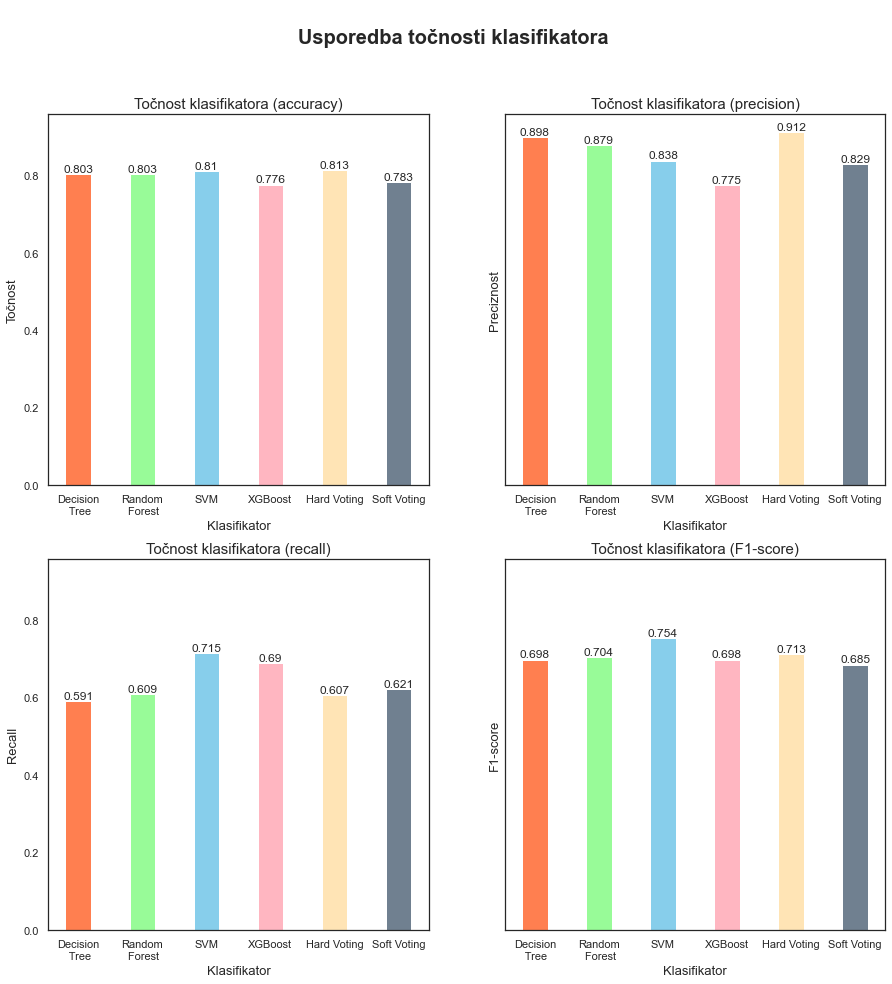

In [53]:

sns.set_style("white")
colors = ["coral","palegreen","skyblue","lightpink","moccasin","slategray"]
accuracy = {'Decision\n Tree':round(average_accuracy_dt,3), 'Random\n Forest':round(average_accuracy_rf,3), 'SVM':round(average_accuracy_svm,3),'XGBoost':round(average_accuracy_xgb,3), 'Hard Voting':round(average_accuracy_vh,3),'Soft Voting':round(average_accuracy_vs,3)}
classifiers = list(accuracy.keys())
accuracies  = list(accuracy.values())

precision = {'Decision\n Tree':round(average_precision_dt,3), 'Random\n Forest':round(average_precision_rf,3), 'SVM':round(average_precision_svm,3),'XGBoost':round(average_precision_xgb,3), 'Hard Voting':round(average_precision_vh,3),'Soft Voting':round(average_precision_vs,3)}
precisions  = list(precision.values())

recall = {'Decision\n Tree':round(average_recall_dt,3), 'Random\n Forest':round(average_recall_rf,3), 'SVM':round(average_recall_svm,3),'XGBoost':round(average_recall_xgb,3), 'Hard Voting':round(average_recall_vh,3),'Soft Voting':round(average_recall_vs,3)}
recalls  = list(recall.values())

f1dict = {'Decision\n Tree':round(average_f1_dt,3), 'Random\n Forest':round(average_f1_rf,3), 'SVM':round(average_f1_svm,3),'XGBoost':round(average_f1_xgb,3), 'Hard Voting':round(average_f1_vh,3), 'Soft Voting':round(average_f1_vs,3)}
f1scores  = list(f1dict.values())


fig, axes = plt.subplots(2,2, sharey = True, figsize = (15, 15))

fig.suptitle("\nUsporedba točnosti klasifikatora",weight = "bold",fontsize = 20)


bars = axes[0,0].bar(classifiers, accuracies, color = colors,width = 0.4)
axes[0,0].bar_label(bars,size = 12)
axes[0,0].set_xlabel("Klasifikator")
axes[0,0].set_ylabel("Točnost")
axes[0,0].set_title("Točnost klasifikatora (accuracy)")
axes[0,0].title.set_fontsize(15)
for item in ( [] + axes[0,0].get_xticklabels() + axes[0,0].get_yticklabels()):
    item.set_fontsize(11)
axes[0,0].xaxis.label.set_fontsize(13) 
axes[0,0].yaxis.label.set_fontsize(13)

bars = axes[0,1].bar(classifiers, precisions, color = colors,width = 0.4)
axes[0,1].bar_label(bars,size = 12)
axes[0,1].set_xlabel("Klasifikator")
axes[0,1].set_ylabel("Preciznost")
axes[0,1].set_title("Točnost klasifikatora (precision)")
axes[0,1].title.set_fontsize(15)
for item in ( [] + axes[0,1].get_xticklabels() + axes[0,1].get_yticklabels()):
    item.set_fontsize(11)
axes[0,1].xaxis.label.set_fontsize(13) 
axes[0,1].yaxis.label.set_fontsize(13)

bars = axes[1,0].bar(classifiers, recalls, color = colors,width = 0.4)
axes[1,0].bar_label(bars,size = 12)
axes[1,0].set_xlabel("Klasifikator")
axes[1,0].set_ylabel("Recall")
axes[1,0].set_title("Točnost klasifikatora (recall)")
axes[1,0].title.set_fontsize(15)
for item in ( [] + axes[1,0].get_xticklabels() + axes[1,0].get_yticklabels()):
    item.set_fontsize(11)
axes[1,0].xaxis.label.set_fontsize(13) 
axes[1,0].yaxis.label.set_fontsize(13)

bars = axes[1,1].bar(classifiers, f1scores, color = colors ,width = 0.4)
axes[1,1].bar_label(bars,size = 12)
axes[1,1].set_xlabel("Klasifikator")
axes[1,1].set_ylabel("F1-score")
axes[1,1].set_title("Točnost klasifikatora (F1-score)");
axes[1,1].title.set_fontsize(15)
for item in ( [] + axes[1,1].get_xticklabels() + axes[1,1].get_yticklabels()):
    item.set_fontsize(11)
axes[1,1].xaxis.label.set_fontsize(13) 
axes[1,1].yaxis.label.set_fontsize(13)


Prema točnosti klasifikatora (accuracy) se ni jedan klasifikator ne ističe, modeli su trenirani tako da bi se ova mjera optimirala te je za sve modele osim za XGBoost postignuta točnost od 80%.

Prema preciznosti se ističe **Decision Tree i Hard Voting** klasifikator.

Prema recallu i F1-rezultatu se ističe **SVM** pa bi se moglo zaključiti da je to najbolji klasifikator.

Klasifikator **XGBoost** ima drugi najbolji rezultat po metrici recall, ali najlošiju preciznost. Prema F1-rezultatu je malo lošiji od klasifikatora **Random Forest** te ovisno koja je metrika važnija, izabrao bi se odgovarajući klasifikator. S obzirom da je cilj detektirati bolest, možemo reći da je važnije imati bolji recall - detektirati što više oboljelih pa makar imali nešto više lažnih pozitiva.

Kako bi se procjenila efikasnost klasifikatora koriste se i **matrice zabune** na kojima se vidi odnos pravih (oni koji imaju Alzheimer i model im ga je predvidio) i lažnih pozitiva (oni koji nemaju Alzheimer, a model ga im je predvidio).

Optimalan model ima velik udio pravih pozitiva i malen udio lažnih pozitiva, ali u praksi je potrebno pronaći balans između mjera točnosti jer ni jedan model nije optimalan po svim kriterijima.

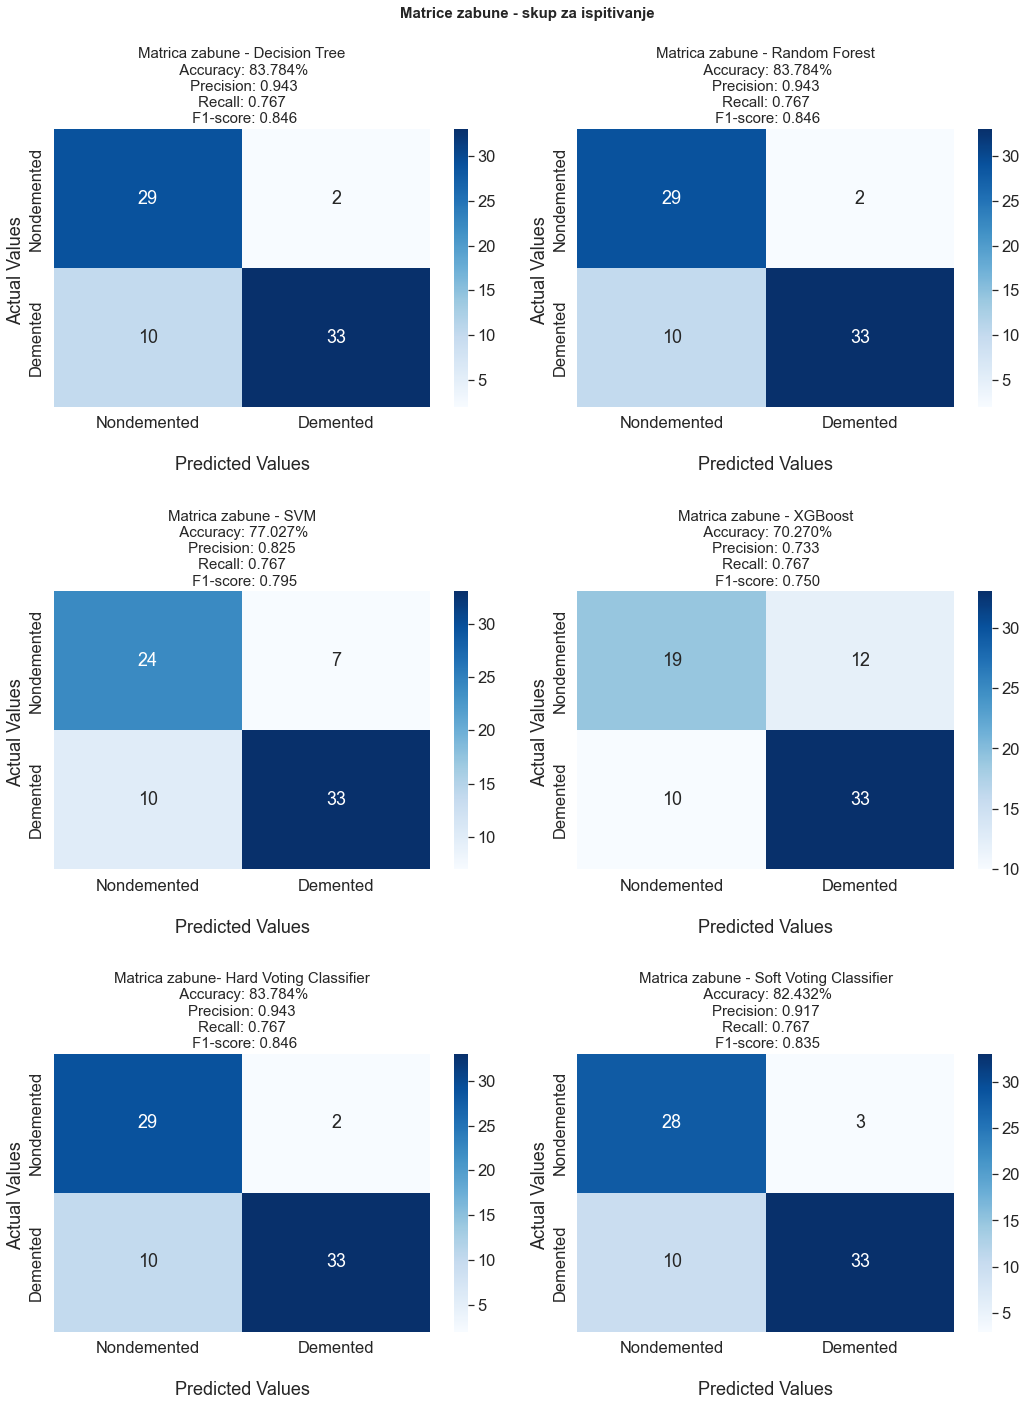

In [54]:
fig, axes = plt.subplots(3,2, figsize = (15, 20))
fig.suptitle("Matrice zabune - skup za ispitivanje",weight = "bold", fontsize = 15)

cf_matrix = confusion_matrix(test_Y, dt_predictions)
dt_accuracy = accuracy_score(test_Y,dt_predictions)*100
dt_precision= precision_score(test_Y,dt_predictions)
dt_recall = recall_score(test_Y,dt_predictions)
dt_f1 = f1_score(test_Y,dt_predictions)

sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[0,0])

axes[0,0].set_title(f'\nMatrica zabune - Decision Tree\n Accuracy: {dt_accuracy:.3f}%\n Precision: {dt_precision:.3f}\n Recall: {dt_recall:.3f} \n F1-score: {dt_f1:.3f}');
axes[0,0].set_xlabel('\nPredicted Values')
axes[0,0].set_ylabel('Actual Values ');
axes[0,0].title.set_fontsize(15)
axes[0,0].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[0,0].yaxis.set_ticklabels(['Nondemented','Demented'])



cf_matrix = confusion_matrix(test_Y, rf_predictions)
rf_accuracy = accuracy_score(test_Y,rf_predictions)*100
rf_precision= precision_score(test_Y,rf_predictions)
rf_recall = recall_score(test_Y,rf_predictions)
rf_f1 = f1_score(test_Y,rf_predictions)

sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[0,1])

axes[0,1].set_title(f'\nMatrica zabune - Random Forest\n Accuracy: {rf_accuracy:.3f}%\nPrecision: {rf_precision:.3f}\n Recall: {rf_recall:.3f} \n F1-score: {rf_f1:.3f}');
axes[0,1].set_xlabel('\nPredicted Values')
axes[0,1].set_ylabel('Actual Values ');
axes[0,1].title.set_fontsize(15)
axes[0,1].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[0,1].yaxis.set_ticklabels(['Nondemented','Demented'])


cf_matrix = confusion_matrix(test_Y, svm_predictions)
svm_accuracy = accuracy_score(test_Y,svm_predictions)*100
svm_precision= precision_score(test_Y,svm_predictions)
svm_recall = recall_score(test_Y,svm_predictions)
svm_f1 = f1_score(test_Y,svm_predictions)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[1,0])

axes[1,0].set_title(f'\nMatrica zabune - SVM\n Accuracy: {svm_accuracy:.3f}%\n Precision: {svm_precision:.3f} \n Recall: {svm_recall:.3f} \n F1-score: {svm_f1:.3f}');
axes[1,0].set_xlabel('\nPredicted Values')
axes[1,0].set_ylabel('Actual Values ');
axes[1,0].title.set_fontsize(15)
axes[1,0].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[1,0].yaxis.set_ticklabels(['Nondemented','Demented'])

cf_matrix = confusion_matrix(test_Y, xgb_predictions)
xgb_accuracy = accuracy_score(test_Y,xgb_predictions)*100
xgb_precision= precision_score(test_Y,xgb_predictions)
xgb_recall = recall_score(test_Y,xgb_predictions)
xgb_f1 = f1_score(test_Y,xgb_predictions)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[1,1])

axes[1,1].set_title(f'\nMatrica zabune - XGBoost\n Accuracy: {xgb_accuracy:.3f}%\n Precision: {xgb_precision:.3f} \n Recall: {xgb_recall:.3f} \n F1-score: {xgb_f1:.3f}');
axes[1,1].set_xlabel('\nPredicted Values')
axes[1,1].set_ylabel('Actual Values ');
axes[1,1].title.set_fontsize(15)
axes[1,1].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[1,1].yaxis.set_ticklabels(['Nondemented','Demented'])


cf_matrix = confusion_matrix(test_Y, vc_predictions)
vh_accuracy = accuracy_score(test_Y,vc_predictions)*100
vh_precision= precision_score(test_Y,vc_predictions)
vh_recall = recall_score(test_Y,vc_predictions)
vh_f1 = f1_score(test_Y,vc_predictions)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[2,0])

axes[2,0].set_title(f'\nMatrica zabune- Hard Voting Classifier\n Accuracy: {vh_accuracy:.3f}%\nPrecision: {vh_precision:.3f}\n Recall: {vh_recall:.3f} \n F1-score: {vh_f1:.3f}');
axes[2,0].set_xlabel('\nPredicted Values')
axes[2,0].set_ylabel('Actual Values ');
axes[2,0].title.set_fontsize(15)
axes[2,0].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[2,0].yaxis.set_ticklabels(['Nondemented','Demented'])

cf_matrix = confusion_matrix(test_Y, vc_s_predictions)
vs_accuracy = accuracy_score(test_Y,vc_s_predictions)*100
vs_precision= precision_score(test_Y,vc_s_predictions)
vs_recall = recall_score(test_Y,vc_s_predictions)
vs_f1 = f1_score(test_Y,vc_s_predictions)
sns.heatmap(cf_matrix, annot=True, cmap='Blues',ax = axes[2,1])

axes[2,1].set_title(f'\nMatrica zabune - Soft Voting Classifier\n Accuracy: {vs_accuracy:.3f}%\nPrecision: {vs_precision:.3f}\n Recall: {vs_recall:.3f} \n F1-score: {vs_f1:.3f}');
axes[2,1].set_xlabel('\nPredicted Values')
axes[2,1].set_ylabel('Actual Values ');
axes[2,1].title.set_fontsize(15)
axes[2,1].xaxis.set_ticklabels(['Nondemented','Demented'])
axes[2,1].yaxis.set_ticklabels(['Nondemented','Demented']);

plt.tight_layout()

Prema matricama zabune (na skupu za ispitivanje) najbolji su klasifikatori **Decision Tree, Random Forest i Hard Voting Classifier**. XGB klasifikator se pokazao najlošijim po kriteriju preciznosti. Ima 12 lažnih pozitiva (predviđen Alzheimer, a subjekt ga nema). Zanimljivo da su ovdje drugi klasifikatori dali preciznije predikcije od SVM-a, iako je unakrsna provjera pokazala da je jako dobar.

## **USPOREDBA DOBIVENIH REZULTATA S REZULTATIMA IZ ČLANKA**

Najveća razlika u pristupu je ta da su autori članka koristili *slučajnu podjelu* na skup za učenje i skup za ispitivanje. Takav pristup pri longitudinalnoj studiji nije dobar jer se dio informacija iz skupa za ispitivanje može naći i u skupu za treniranje.

U članku nije detaljno opisana optimizacija hiperparametara modela što je također dovelo do odstupanja rezultata. I meni i njima se klasifikator Random Forest pokazao dobar, ali njihovi su rezultati s XGB klasifikatorom bolji od mojih. U mom se radu boljim klasifikatorom pokazao SVM. Budući da je najveća razlika mojih modela bila za XGB klasifikator napravila sam slučajnu podjelu po njihovim uputama. Dobivene metrike su značajno veće, ali takva je podjela neadekvatna za ovaj podatkovni skup.

In [55]:
tX,ttX,ty,tty = train_test_split(data.loc[:,data.columns.isin(["Gender", "Age", "EDUC", "SES", "MMSE", "eTIV","nWBV"])], data.loc[:,'Demention'], test_size=0.2, random_state = 8)

clf = XGBClassifier(objective = "reg:logistic", n_estimators = 20, reg_lambda = 1, max_depth = 5)
clf.fit(tX,ty)
    
xgb_predictions = clf.predict(ttX)

xgb_accuracy = accuracy_score(tty,xgb_predictions)
print(f"accuracy na test skupu - uz potencijalni data leakage: {xgb_accuracy:.3f}")

scores = cross_val_score(clf, tX, ty, cv=10)
score = scores.mean()
print(f"accuracy (unakrsna validacija)- uz potencijalni data leakage: {score:.3f}")

scores = cross_val_score(clf, tX, ty, cv=10,scoring = 'precision')
score = scores.mean()
print(f"precision (unakrsna validacija) - uz potencijalni data leakage: {score:.3f}")

scores = cross_val_score(clf, tX, ty, cv=10,scoring = 'recall')
score = scores.mean()
print(f"recall (unakrsna validacija) - uz potencijalni data leakage: {score:.3f}")

scores = cross_val_score(clf, tX, ty, cv=10,scoring = 'f1')
score = scores.mean()
print(f"f1 score (unakrsna validacija) - uz potencijalni data leakage: {score:.3f}")

accuracy na test skupu - uz potencijalni data leakage: 0.827
accuracy (unakrsna validacija)- uz potencijalni data leakage: 0.802
precision (unakrsna validacija) - uz potencijalni data leakage: 0.820
recall (unakrsna validacija) - uz potencijalni data leakage: 0.720
f1 score (unakrsna validacija) - uz potencijalni data leakage: 0.763
